BDS^3 2024
=====

## Реконструкція біофізичних властивостей Ca<sup>2+</sup>-зв'язуючих білків за результами конфокальної мікроскопії
---
_Borys Olifirov, 07.2024, Uzhhorod_

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

from scipy import signal
from scipy import stats

import numpy as np
from numpy import ma

import pandas as pd

from skimage import io
from skimage import filters
from skimage import measure
from skimage import morphology

import sympy as sp

# 1. Біофізика процесу зв'язування ліганда
---

## Зв'язування одного ліганду. Ізотерма Ленгмюра

Рівняння зв'язування білком __P__ одного ліганда __L__ (реакція другого порядку):
$$
P + L \rightleftharpoons PL
$$

Загальна концентрація білка (__[P]0__) та ліганда (__[L]0__) є сумої концентрації їх вільних (__[P]__, __[L]__) та зв'язаних (__[PL]__) форм:
$$
[P]_0 = [P] + [PL]
$$
$$
[L]_0 = [L] + [PL]
$$


$$
K_d = \frac{[P] \cdot [L]}{[PL]}
$$




In terms of the concentration of protein bounded form __[PL]__ or fraction of bound protein __Y__ we can rewrite the equation:
$$
Y = \frac{[PL]}{[P]_0}
$$

$$
[PL] = [P]_0 \frac{[L]}{K_d + [L]} \Leftrightarrow Y = \frac{[L]}{K_d + [L]} 
$$

           Cₗ  
Y(Cₗ) = ───────
        Cₗ + Kₐ


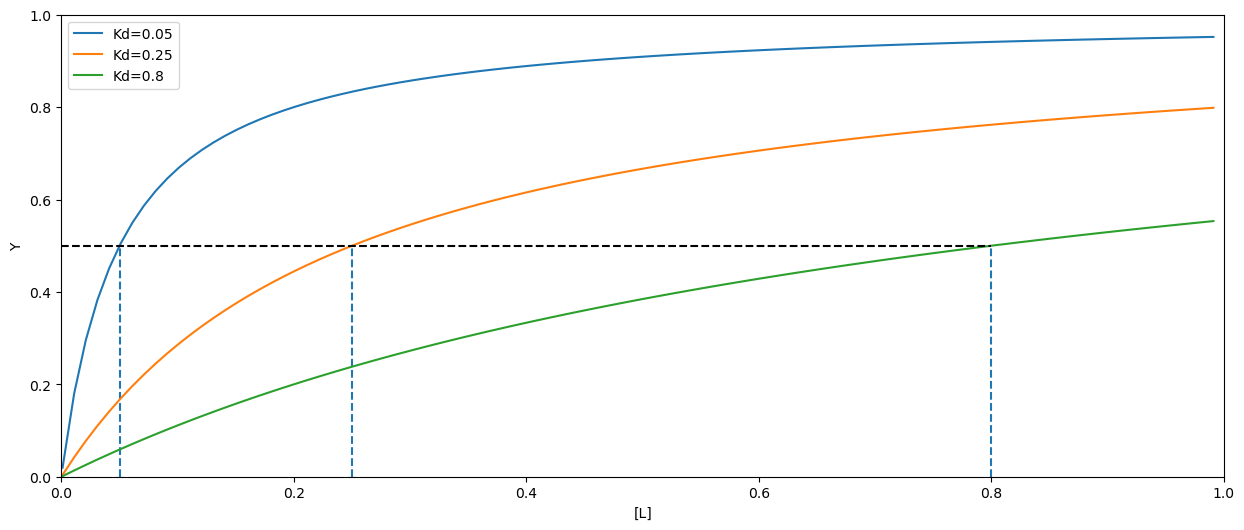

In [2]:
# параметри моделі
Kd_1_val = 0.05
Kd_2_val = 0.25
Kd_3_val = 0.8

c_l = np.arange(0.001, 1, 0.01)  # масив значень концентранції ліганда, від 0.001 до 1

# модель рівняння Ленгмюра
K_d, C_L = sp.symbols('K_a, C_l')
Y = sp.Function('Y')(C_L)
lang_eq = sp.Eq(Y, C_L/(C_L + K_d))

sp.pprint(lang_eq)

lang_eq_sol_Kd_1 = sp.lambdify(C_L, lang_eq.subs({K_d: Kd_1_val}).rhs, 'numpy') 
lang_eq_sol_Kd_2 = sp.lambdify(C_L, lang_eq.subs({K_d: Kd_2_val}).rhs, 'numpy') 
lang_eq_sol_Kd_3 = sp.lambdify(C_L, lang_eq.subs({K_d: Kd_3_val}).rhs, 'numpy') 

# відображення графіків
plt.figure(figsize=(15,6))
plt.plot(c_l, lang_eq_sol_Kd_1(c_l), label=f'Kd={Kd_1_val}')
plt.vlines(x=Kd_1_val, ymin=0, ymax=0.5, linestyles='--')

plt.plot(c_l, lang_eq_sol_Kd_2(c_l), label=f'Kd={Kd_2_val}')
plt.vlines(x=Kd_2_val, ymin=0, ymax=0.5, linestyles='--')

plt.plot(c_l, lang_eq_sol_Kd_3(c_l), label=f'Kd={Kd_3_val}')
plt.vlines(x=Kd_3_val, ymin=0, ymax=0.5, linestyles='--')

plt.hlines(y=0.5, xmin=0, xmax=Kd_3_val, linestyles='--', color='k')

plt.xlim([0, 1])
plt.xlabel('[L]')

plt.ylim([0, 1])
plt.ylabel('Y')

plt.legend()
plt.show()

## Зв'язування декілької лігандів та кооперетивність

$$
Y = \frac{[L]^h}{K_d + [L]^h} = \frac{[L]^h}{K_A^h + [L]^h}
$$

$$
\log(\frac{Y}{1-Y}) = h \log[L] + \log K_A
$$

                 h   
             Cᵢₒₙ    
Y(Cᵢₒₙ) = ───────────
              h     h
          Cᵢₒₙ  + Kₐ 


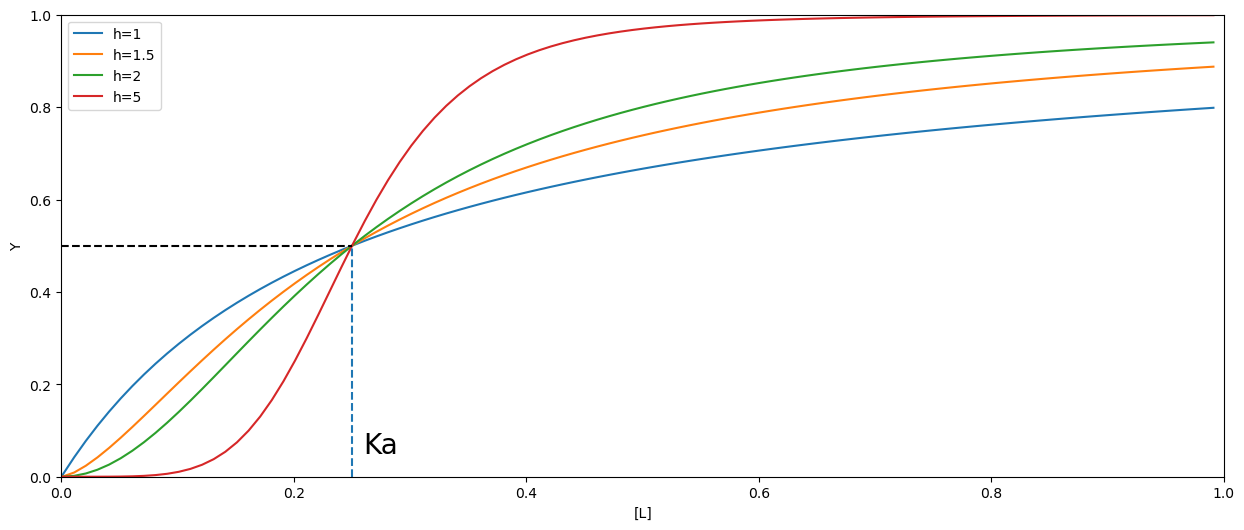

In [3]:
# c_l = np.arange(0, 1, 0.01)
h_list = [1, 1.5, 2, 5]
K_A_val = 0.25

h, K_A, C_L = sp.symbols('h  K_a C_ion')
Y = sp.Function('Y')(C_L)
hill_eq = sp.Eq(Y, C_L**h/(K_A**h + C_L**h))

sp.pprint(hill_eq, use_unicode=True)

hill_profiles_dict = {}
hill_ln_dict = {}
for h_val in h_list:
	hill_eq_sol = sp.lambdify(C_L, hill_eq.subs({h : h_val, K_A : 0.25}).rhs, "numpy")
	hill_profiles_dict.update({h_val:hill_eq_sol(c_l)})

# відображення графіків
plt.figure(figsize=(15,6))
for h_prof in hill_profiles_dict.keys():
	plt.plot(c_l, hill_profiles_dict[h_prof], label=f'h={h_prof}')

plt.text(x=0.26,y=0.05,s='Ka', size=20)

plt.vlines(x=K_A_val, ymin=0, ymax=0.5, linestyles='--')
plt.hlines(y=0.5, xmin=0, xmax=K_A_val, linestyles='--', color='k')

plt.xlim([0, 1])
plt.xlabel('[L]')

plt.ylim([0, 1])
plt.ylabel('Y')

plt.legend()
plt.show()

## Рівняння Хіла

$$
Y = \frac{[L]^h}{K_d + [L]^h} = \frac{[L]^h}{K_A^h + [L]^h}
$$

$$
\frac{Y}{1-Y} = \frac{[L]^h}{K_d} = \frac{[L]^h}{K_A^h}
$$

$$
\log(\frac{Y}{1-Y}) = h \log[L] + \log K_d = h \log[L] + h \log K_A \Leftrightarrow y = bx + a
$$

   ⎛  Y(Cᵢₒₙ)  ⎞                          
log⎜───────────⎟ = h⋅log(Cᵢₒₙ) + h⋅log(Kₐ)
   ⎝1 - Y(Cᵢₒₙ)⎠                          


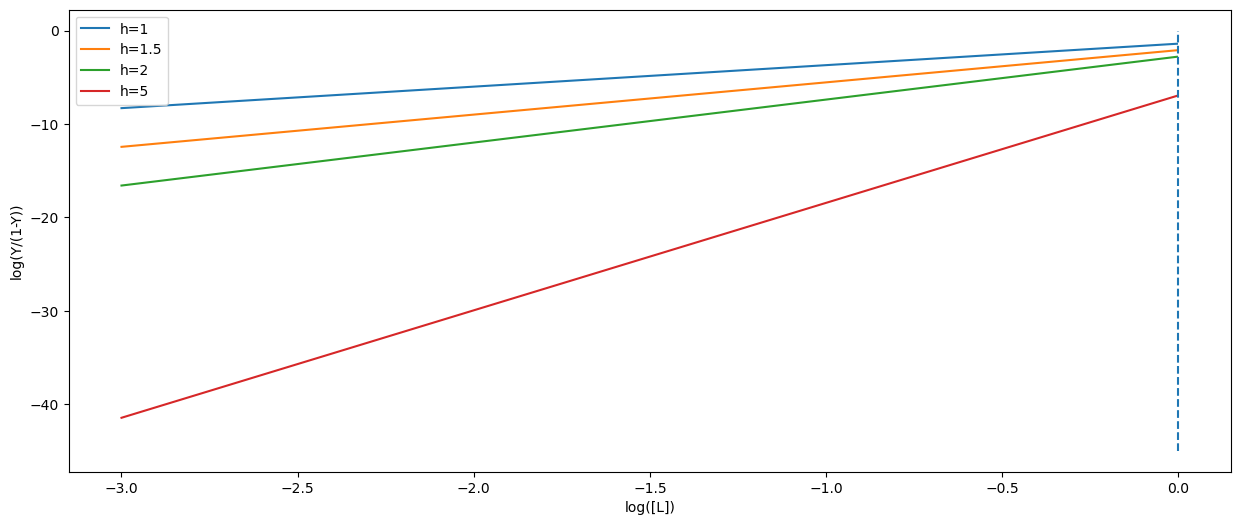

In [4]:
# c_l = np.arange(0, 1, 0.01)
h_list = [1, 1.5, 2, 5]
K_A_val = 0.25

h, K_A, C_L = sp.symbols('h  K_a C_ion')
Y = sp.Function('Y')(C_L)
hill_eq_ln = sp.Eq(sp.log(Y/(1-Y)), h * sp.log(C_L) + h * sp.log(K_A))

sp.pprint(hill_eq_ln, use_unicode=True)

hill_ln_dict = {}
for h_val in h_list:
	hill_ln_sol = sp.lambdify(C_L, hill_eq_ln.subs({h : h_val, K_A : 0.25}).rhs, "numpy")
	hill_ln_dict.update({h_val:hill_ln_sol(c_l)})

# відображення графіків
log_c_l = np.log10(c_l)

plt.figure(figsize=(15,6))
for h_prof in hill_ln_dict.keys():
	plt.plot(log_c_l, hill_ln_dict[h_prof], label=f'h={h_prof}')

plt.vlines(x=0, ymin=-45, ymax=0, linestyles='--')

plt.xlabel('log([L])')
plt.ylabel('log(Y/(1-Y))')

plt.legend()
plt.show()

# 2. Багатовимірні массиви та структура мікроскопічних даних
---

## Аналіз даних

#### Завантаження зображень та розділення каналів

In [5]:
# завантаження зображень
img_raw = io.imread("data/project_data/24_03_22_cell04_01.tiff")
# img_raw = io.imread("data/project_data/23_03_11_cell2_single_8percent_20us.tiff")
print(img_raw.shape)


# розділення окремих каналів
ch0_img_raw = img_raw[0]
ch1_img_raw = img_raw[1]
ch2_img_raw = img_raw[2]
print(ch0_img_raw.shape) 

(3, 45, 320, 320)
(45, 320, 320)


#### Проекції серії знімків

Проекція максимальної інтенсивності пікселів

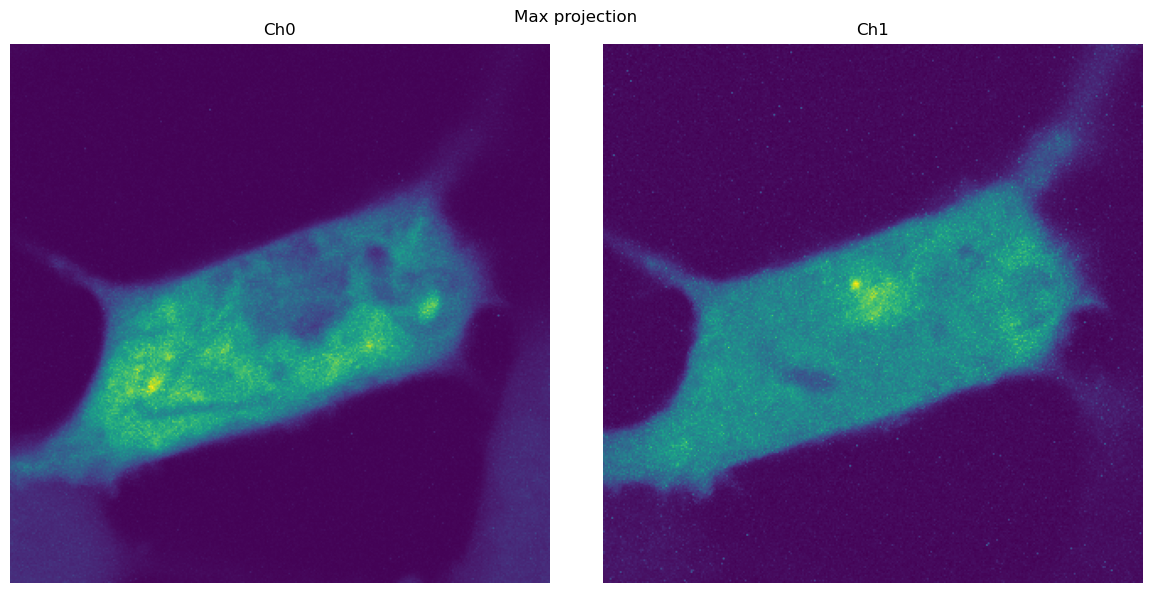

In [6]:
# проекції максимума для окремих каналів
ch0_img_raw_max = np.max(ch0_img_raw, axis=0)
ch1_img_raw_max = np.max(ch1_img_raw, axis=0)


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # зображення каналу 1
ax0.imshow(ch0_img_raw_max)
ax0.set_title('Ch0')
ax0.axis('off')

ax1 = plt.subplot(122)  # зображення каналу 2
ax1.imshow(ch1_img_raw_max)
ax1.set_title('Ch1')
ax1.axis('off')

plt.suptitle('Max projection')
plt.tight_layout()
plt.show()

Проекція середньої інтенсивності пікселів

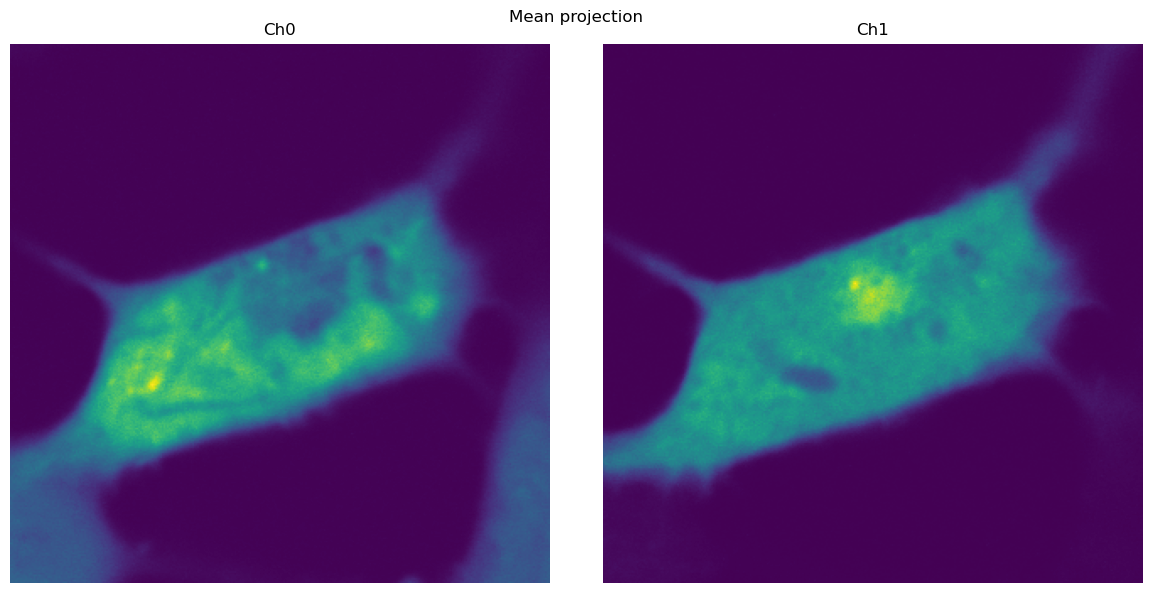

In [7]:
# проекції максимума для окремих каналів
ch0_img_raw_mean = np.mean(ch0_img_raw, axis=0)
ch1_img_raw_mean = np.mean(ch1_img_raw, axis=0)


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # зображення каналу 1
ax0.imshow(ch0_img_raw_mean)
ax0.set_title('Ch0')
ax0.axis('off')

ax1 = plt.subplot(122)  # зображення каналу 2
ax1.imshow(ch1_img_raw_mean)
ax1.set_title('Ch1')
ax1.axis('off')

plt.suptitle('Mean projection')
plt.tight_layout()
plt.show()

#### Кроп серії зображення

Вибір регіону клітини в кадрі

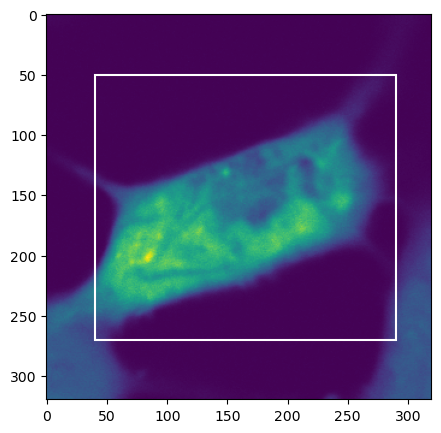

In [8]:
# регіон кропу
x_start, x_end, y_start, y_end = 50, 270, 40, 290

crop_rect = patches.Rectangle((y_start, x_start), y_end-y_start, x_end-x_start,
                              linewidth=1.5, edgecolor='white', facecolor='none')

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(ch0_img_raw_mean)
ax.add_patch(crop_rect)
plt.show()

Кроп всієї серії зображень для кожного з каналів

(45, 220, 250)


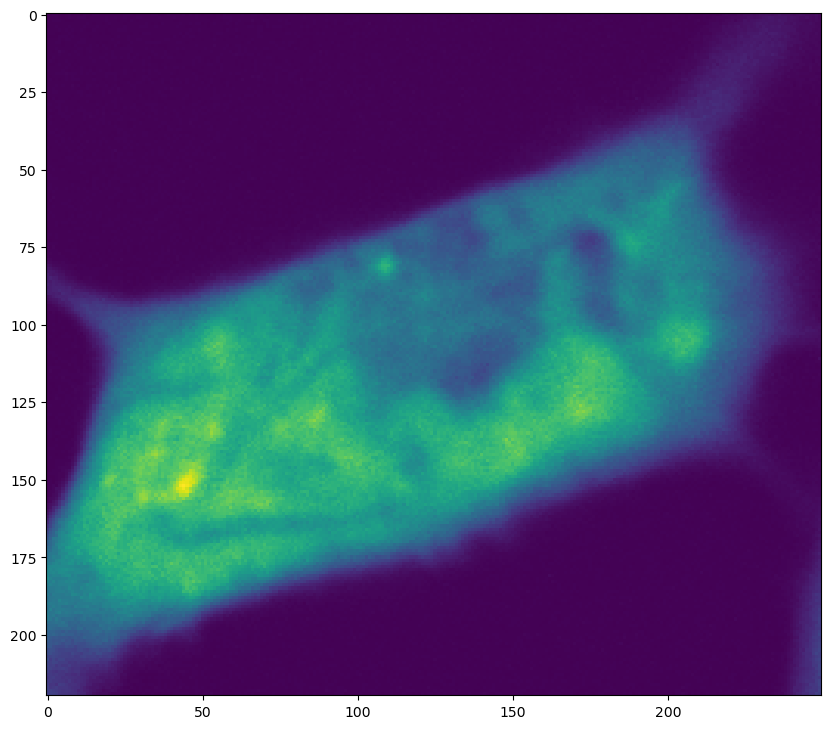

In [9]:
ch0_img_raw_crop = ch0_img_raw[:, x_start:x_end, y_start:y_end]
ch1_img_raw_crop = ch1_img_raw[:, x_start:x_end, y_start:y_end]
print(ch0_img_raw_crop.shape)

# plot
plt.figure(figsize=(10,10))
plt.imshow(np.mean(ch0_img_raw_crop, axis=0))
plt.show()

## Завдання

- __Завантажте експериметальні дані та зробіть кроп лише зони інтересу__

Завантажте будь-який файл з папки `data/project_data`, видільть лише канали інтересу та обріжте зображення щоб клітина займала якнайбільшу частину кадру

Індексація каналів в експериментальних даних:
-  `0` - кальцієвий барвник
- `1` - білок HPCA-TagRFP
- `2` - диференційно-інтерференційний контраст). 

# 3.Попередня обробка даних та побудова масок різних компартментів клітини
---

## Аналіз даних

#### Корекція фонової інтенсивності

Оцінка фонової інтенсивності

In [10]:
# приклад функції
def img_metrics(img):
    print(f'Minimal intensity ={np.min(img)}')
    print(f'Maximal intensity ={np.max(img)}')
    print(f'Average intensity ={np.mean(img)}')
    print(f'Median intensity ={np.median(img)}')

Minimal intensity =129
Maximal intensity =3318
Average intensity =732.1279636363637
Median intensity =281.0


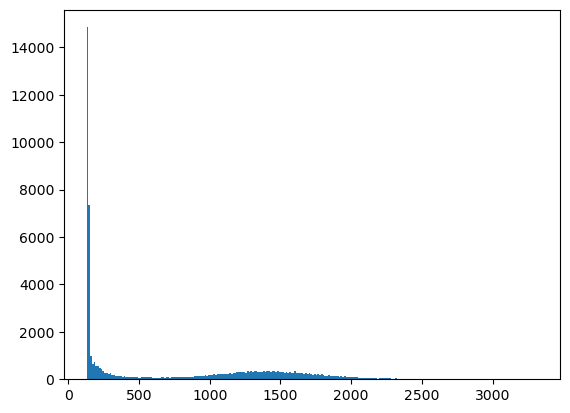

In [11]:
ch1_raw_frame = ch1_img_raw_crop[0]

img_metrics(img=ch1_raw_frame)

plt.hist(ch1_raw_frame.ravel(), bins=256)
plt.show()

Minimal intensity =0
Maximal intensity =3189
Average intensity =603.1279636363637
Median intensity =152.0


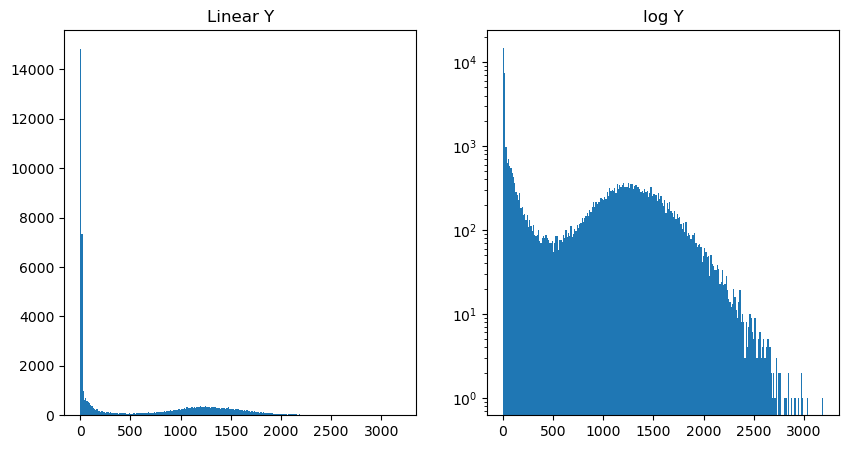

In [12]:
ch1_min_compensate = ch1_raw_frame - 129

img_metrics(ch1_min_compensate)


fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10,5))

ax0.hist(ch1_min_compensate.ravel(), bins=256)
ax0.set_title('Linear Y')

ax1.hist(ch1_min_compensate.ravel(), bins=256)
ax1.set_yscale('log')
ax1.set_title('log Y')

plt.show()

Компенсація фонової інтенсивності для всієї серії знімків

In [13]:
# лямбда-функції
lambda_sum = lambda a,b: a+b

lambda_sum(a=1,b=2)

3

In [14]:
# генератори списків/list comprehension
num_list = list(range(10))
comp_list = [i*2 for i in num_list]

print(num_list)
print(comp_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [15]:
# лямба-функція для корекції фонової інтенсивності
bc_p = lambda x:np.array([f - np.percentile(f, 1) for f in x]).clip(min=0).astype(dtype=x.dtype)

ch0_img_corr = bc_p(ch0_img_raw_crop)
ch1_img_corr = bc_p(ch1_img_raw_crop)

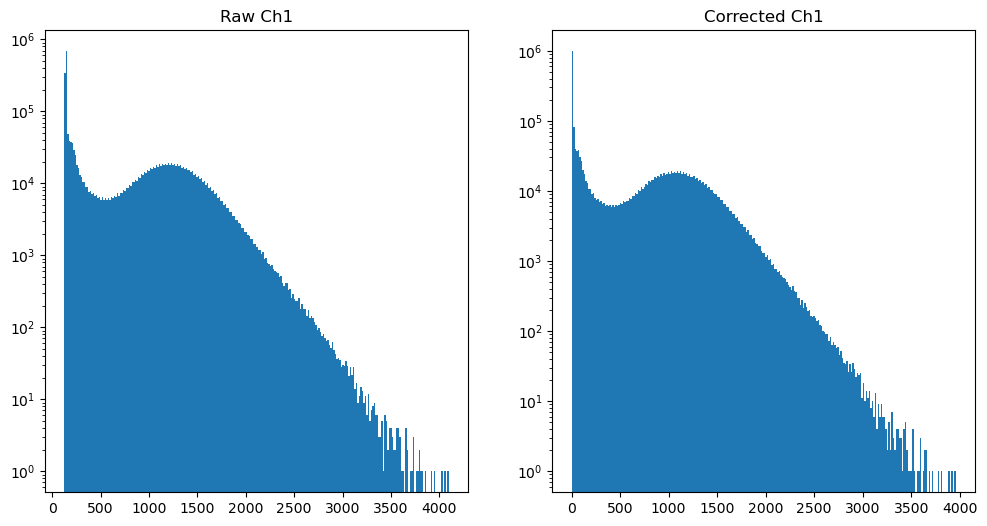

In [16]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,6))

ax0.hist(ch1_img_raw_crop.ravel(), bins=256)
ax0.set_yscale('log')
ax0.set_title('Raw Ch1')

ax1.hist(ch1_img_corr.ravel(), bins=256)
ax1.set_yscale('log')
ax1.set_title('Corrected Ch1')

plt.show()

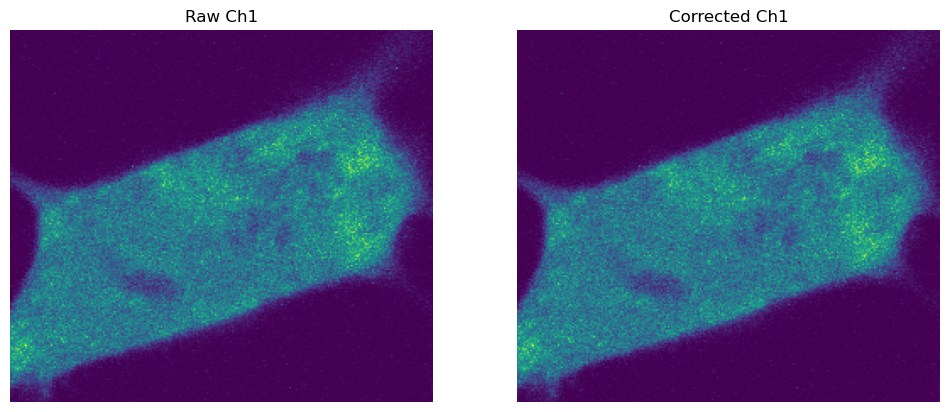

In [17]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,6))

ax0.imshow(ch1_img_raw_crop[0])
ax0.set_title('Raw Ch1')
ax0.axis('off')

ax1.imshow(ch1_img_corr[0])
ax1.set_title('Corrected Ch1')
ax1.axis('off')

plt.show()

#### Детекція та сегментація клітини з використанням мульти-Отсу

"Контрольне" зображення для детекції клітини

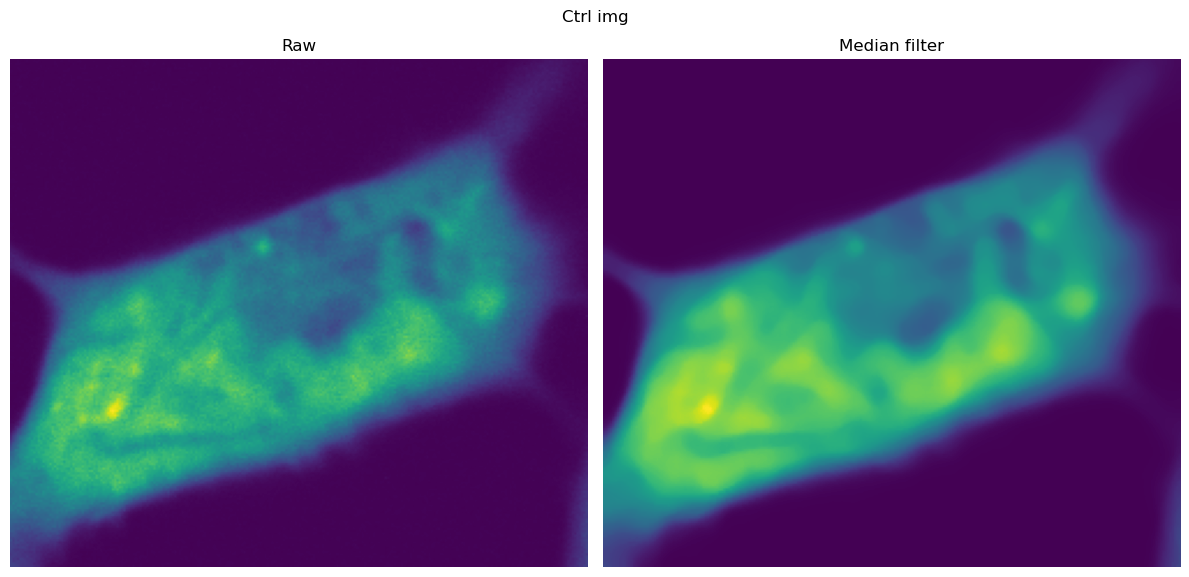

In [18]:
# контрольне зображення для детекції
cell_det_img_raw = np.mean(ch0_img_corr, axis=0)

# фільтрування контрольного зображення
cell_det_img = filters.median(cell_det_img_raw,
                              footprint=morphology.disk(5))


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # сире контрольне зображення
ax0.imshow(cell_det_img_raw)
ax0.set_title('Raw')
ax0.axis('off')

ax1 = plt.subplot(122)  # контрольне зображення після застосування фільтра Гауса
ax1.imshow(cell_det_img)
ax1.set_title('Median filter')
ax1.axis('off')

plt.suptitle('Ctrl img')
plt.tight_layout()
plt.show()

Обчислення порогів мульти-Отсу

[196.03233507 495.08719618]


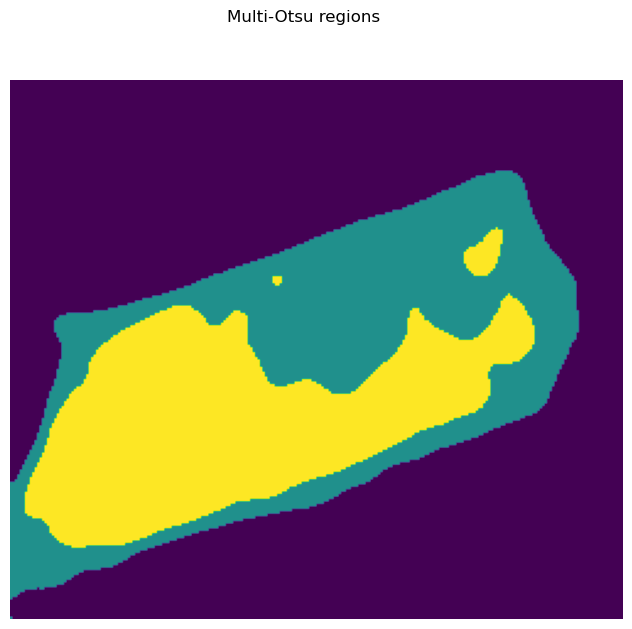

In [19]:
# отримання порогів мульти-Отсу
thresholds = filters.threshold_multiotsu(cell_det_img)
print(thresholds)

# розмежування регіонів за пороговими значеннями
regions_img = np.digitize(cell_det_img, bins=thresholds)


# plot
plt.figure(figsize=(10,7))
plt.imshow(regions_img)  # регіони за порогами мульти-Отсу
plt.suptitle('Multi-Otsu regions')
plt.axis('off')
plt.show()

Побудова масок окремих регіонів

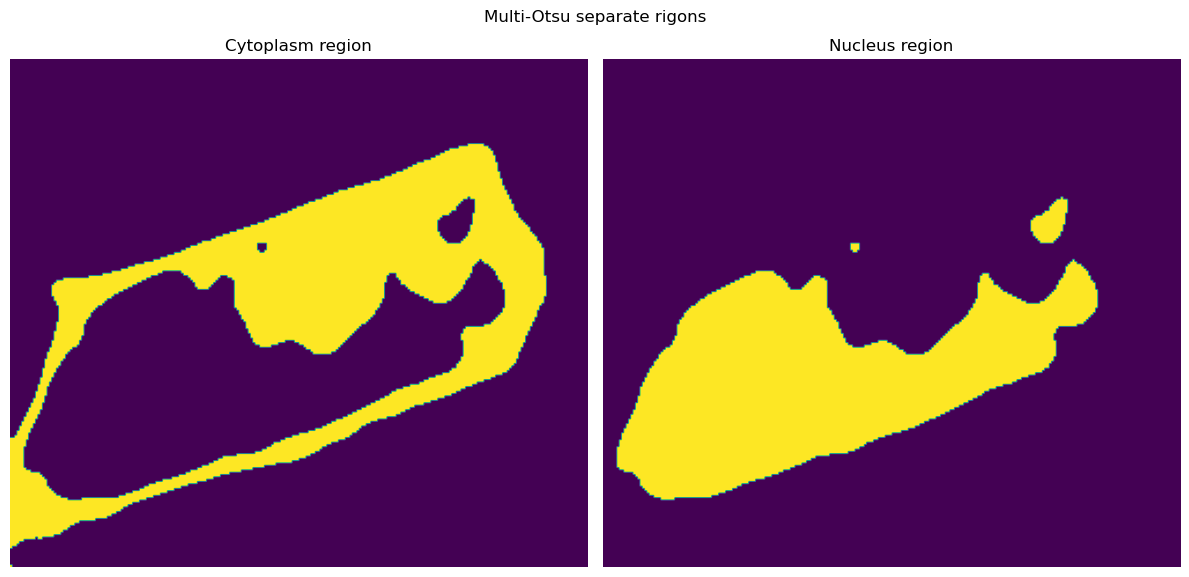

In [20]:
# булеві маски окремих регіонів
cytoplasm_mask_raw = regions_img == 1
nucleus_mask_raw = regions_img == 2


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # регіон цитоплазми
ax0.imshow(cytoplasm_mask_raw)
ax0.set_title('Cytoplasm region')
ax0.axis('off')

ax1 = plt.subplot(122)  # регіон ядра
ax1.imshow(nucleus_mask_raw)
ax1.set_title('Nucleus region')
ax1.axis('off')

plt.suptitle('Multi-Otsu separate rigons')
plt.tight_layout()
plt.show()

#### Побудова масок цитоплазматичного регіону клітини та цілої клітини

Модифікація регіонів

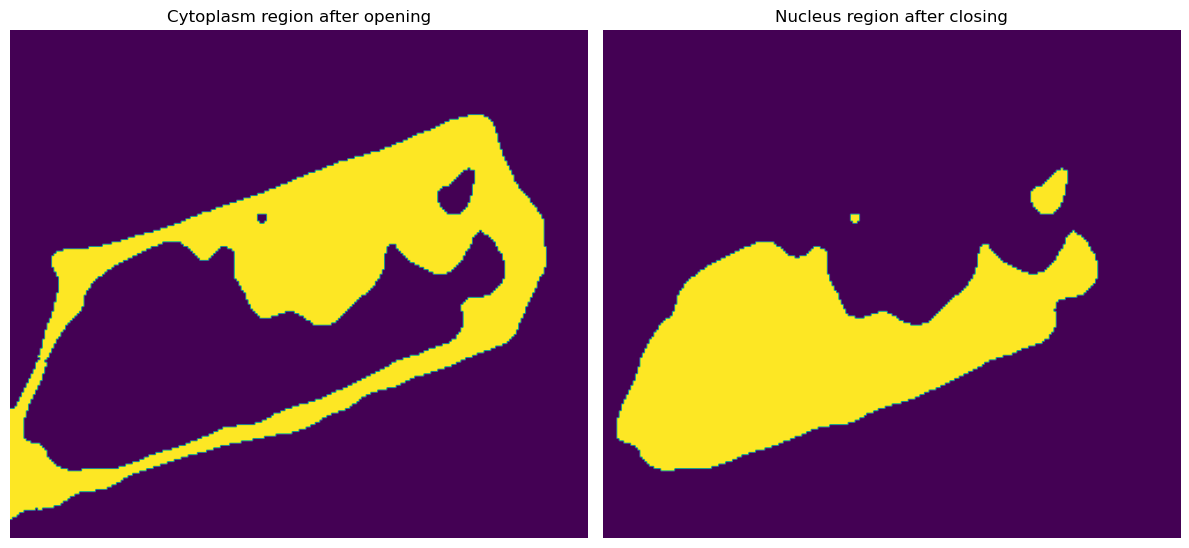

In [21]:
cytoplasm_mask = morphology.opening(cytoplasm_mask_raw, footprint=morphology.disk(2))
nucleus_mask = morphology.closing(nucleus_mask_raw, footprint=morphology.disk(5))


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # регіон цитоплазми
ax0.imshow(cytoplasm_mask)
ax0.set_title('Cytoplasm region after opening')
ax0.axis('off')

ax1 = plt.subplot(122)  # "роздутий" регіон цитоплазми
ax1.imshow(nucleus_mask)
ax1.set_title('Nucleus region after closing')
ax1.axis('off')

plt.tight_layout()
plt.show()

Корегування фінальної маски цитоплазматичного регіону та побудова маски цілої клітини

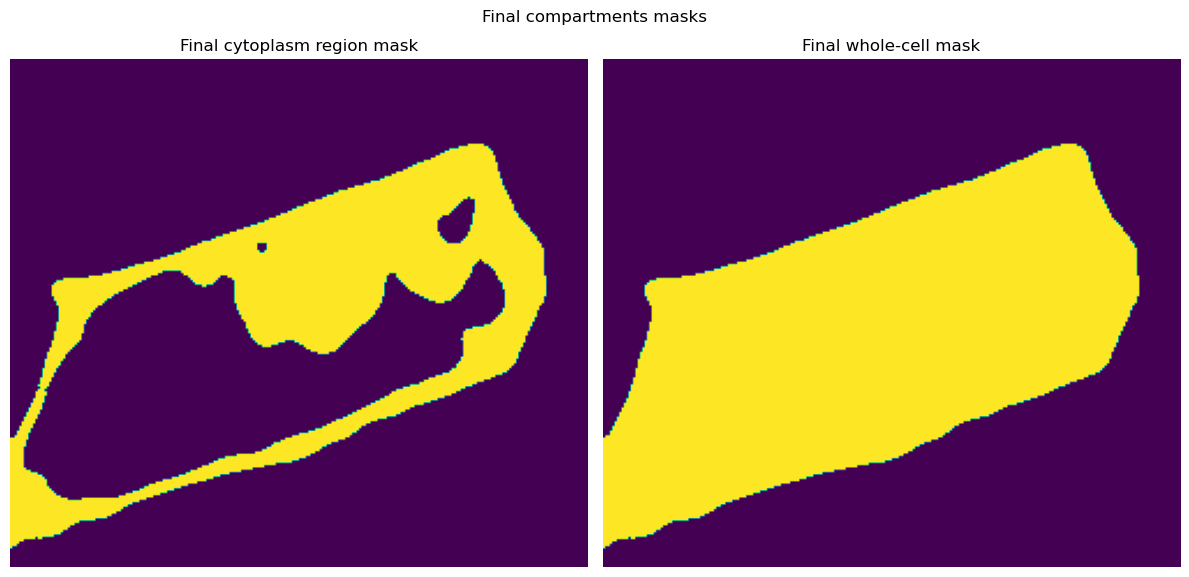

In [22]:
cytoplasm_mask[nucleus_mask] = 0
cell_mask = cytoplasm_mask + nucleus_mask
cell_mask = morphology.closing(cell_mask,
                               footprint=morphology.disk(3))


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # маска цитоплазматичног регіона
ax0.imshow(cytoplasm_mask)
ax0.set_title('Final cytoplasm region mask')
ax0.axis('off')

ax1 = plt.subplot(122)  # маска цілої клітини
ax1.imshow(cell_mask)
ax1.set_title('Final whole-cell mask')
ax1.axis('off')

plt.suptitle('Final compartments masks')
plt.tight_layout()
plt.show()

#### Фільтруція серій зображень обох каналів перед подальшою обробкою

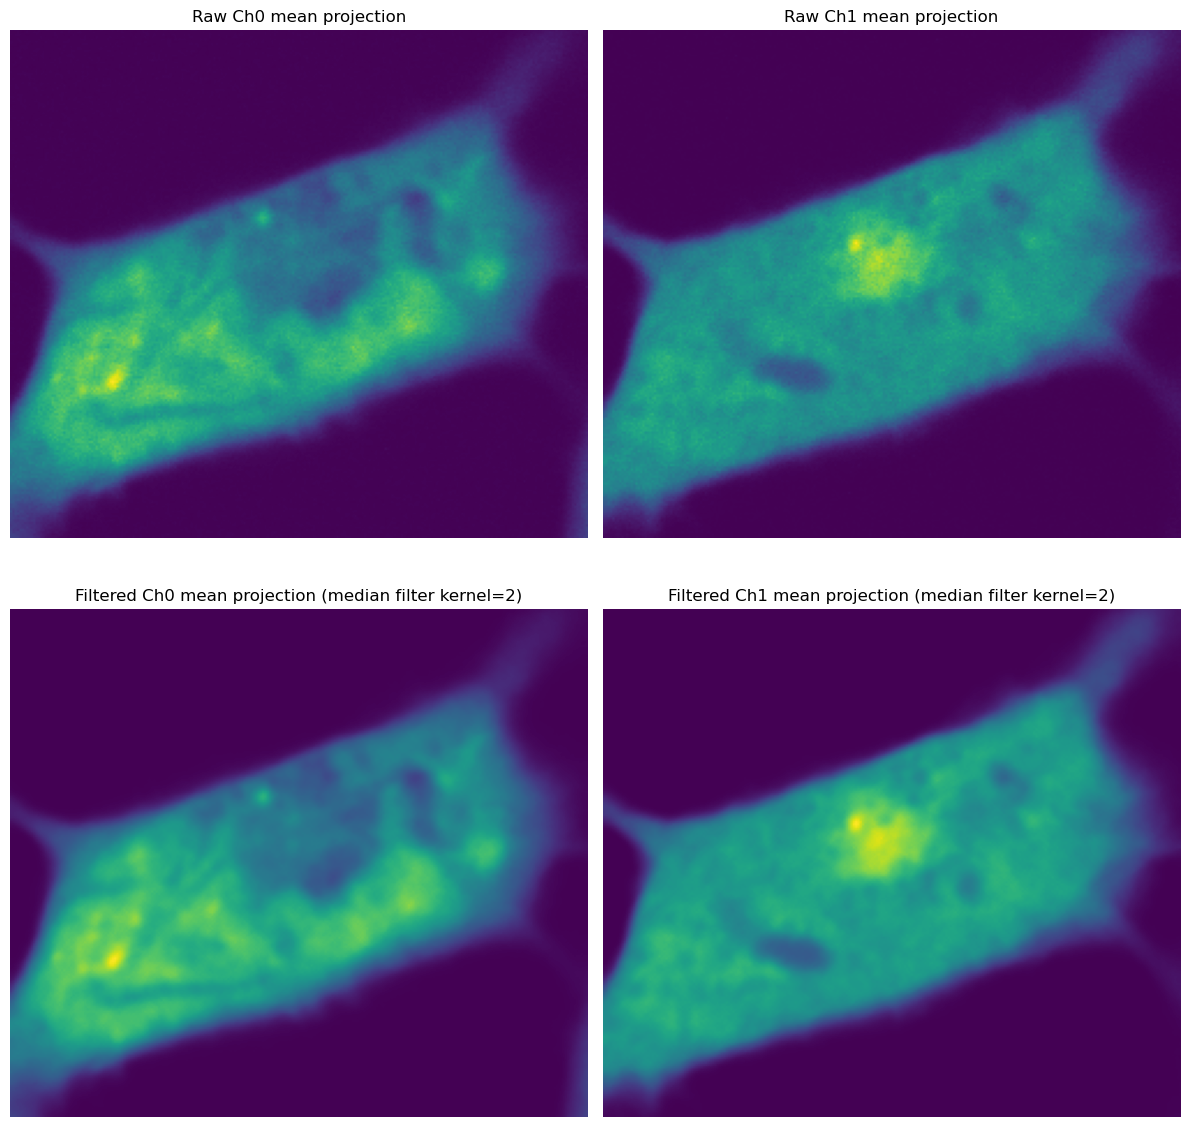

In [23]:
stack_median_filter = lambda img,disk_size: np.asarray([filters.median(frame, footprint=morphology.disk(disk_size)) for frame in img])

median_kernel_size = 2

# фіналізація попердньої обробки зображень
ch0_img_processed = stack_median_filter(ch0_img_corr, median_kernel_size)
ch1_img_processed = stack_median_filter(ch1_img_corr, median_kernel_size)

# plot
plt.figure(figsize=(12,12))

ax0 = plt.subplot(221)  # проекція середньої інтенсивності сирої серії зображень канала кальцієвого барвника
ax0.imshow(np.mean(ch0_img_raw_crop, axis=0))
ax0.set_title('Raw Ch0 mean projection')
ax0.axis('off')

ax1 = plt.subplot(222)  # проекція середньої інтенсивності сирої серії зображень канала флуоресцентного білка
ax1.imshow(np.mean(ch1_img_raw_crop, axis=0))
ax1.set_title('Raw Ch1 mean projection')
ax1.axis('off')

ax2 = plt.subplot(223)  # проекція середньої інтенсивності серії зображень канала кальцієвого барвника після фільтрування
ax2.imshow(np.mean(ch0_img_processed, axis=0))
ax2.set_title(f'Filtered Ch0 mean projection (median filter kernel={median_kernel_size})')
ax2.axis('off')

ax3 = plt.subplot(224)  # проекція середньої інтенсивності серії зображень канала флуоресцентного білка після фільтрування
ax3.imshow(np.mean(ch1_img_processed, axis=0))
ax3.set_title(f'Filtered Ch1 mean projection (median filter kernel={median_kernel_size})')
ax3.axis('off')

plt.tight_layout()
plt.show()

## Завдання

1. __Напишіть функцію для поередньої обробки даних__

Створіть функцію що приймала би на вхід 3D time series і повертала б 3D масив такої ж форми пілся корекції фонової інтенсивності та фільтрації. Аргументом функції окрім зображення має бути розмір `footrpint` для медіанного фільтра.

2. __Напишіть функцію для створення масок різних компартментів клітини з використанням методу мульти Отсу__

Створіть функцію що приймала би на вхід 2D зображення і повертала три маски (всії клітини, ядра та цитоплазми). Аргумантами функції окрім зображення має бути розмір `footprint` для його попереднього розмиття і параметри `footprint` для морфологічної фільтрації масок.

#### Завдання 1

In [24]:
def preprocessing(input_image, median_filter_footprint):
    bc_image = bc_p(input_image)

    # list comprehension
    output_image = np.array([filters.median(frame, footprint=morphology.disk(median_filter_footprint)) for frame in bc_image])
    
    # # for loop
    # output_image = []
    # for frame in bc_image:
    #     filtered_frame = filters.median(frame, footprint=morphology.disk(median_filter_footprint))
    #     output_image.append(filtered_frame)
    # output_image = np.array(output_image)

    return output_image

In [25]:
print(ch0_img_raw.shape)
print(ch0_img_raw.dtype)

preprocessing_output = preprocessing(input_image=ch0_img_raw, median_filter_footprint=4)

print(preprocessing_output.shape)
print(preprocessing_output.dtype)

(45, 320, 320)
uint16
(45, 320, 320)
uint16


#### Завдання 2

In [26]:
def compartments_masking(input_image, closing_footprint, opening_footprint):
    # whole-cell masking
    raw_output_cell_mask = input_image > filters.threshold_otsu(input_image)
    output_cell_mask = morphology.closing(raw_output_cell_mask, footprint=morphology.disk(closing_footprint))

    # cytoplasm masking
    compartments_thresholds = filters.threshold_multiotsu(input_image)
    compartments_regions_img = np.digitize(input_image, bins=compartments_thresholds)
    raw_output_cytoplasm_mask = compartments_regions_img == 1
    output_cytoplasm_mask = morphology.opening(raw_output_cytoplasm_mask, footprint=morphology.disk(opening_footprint))

    return output_cytoplasm_mask, output_cell_mask

(220, 250)
float64
(220, 250)
(220, 250)


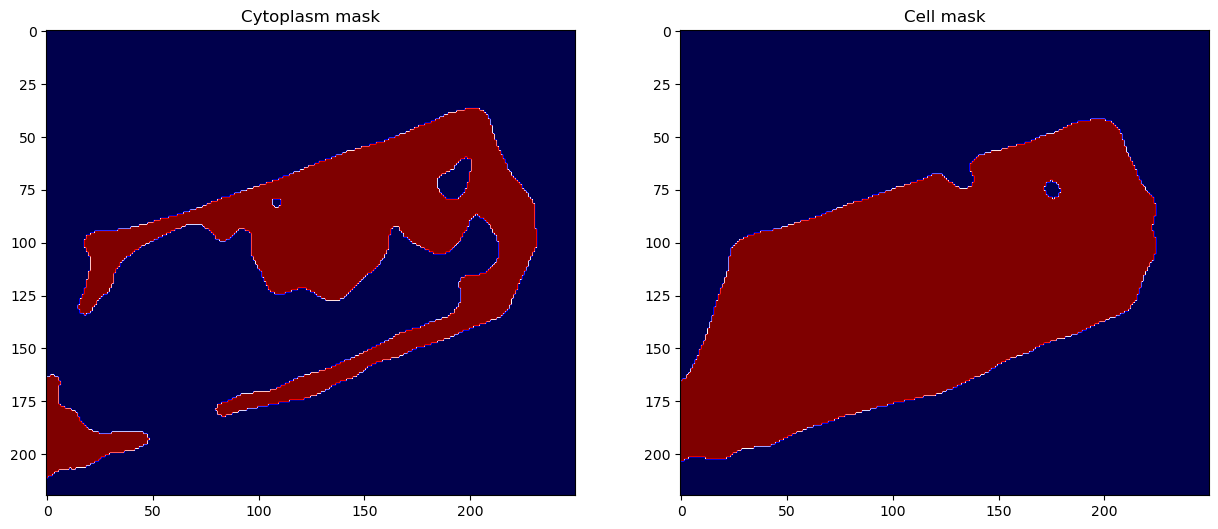

In [27]:
print(cell_det_img.shape)
print(cell_det_img.dtype)

masking_cytplasm_output, masking_cell_output = compartments_masking(input_image=cell_det_img, closing_footprint=3, opening_footprint=3)

print(masking_cytplasm_output.shape)
print(masking_cell_output.shape)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,7))
ax0.imshow(masking_cytplasm_output, cmap='seismic')
ax0.set_title('Cytoplasm mask')
ax1.imshow(masking_cell_output, cmap='seismic')
ax1.set_title('Cell mask')
plt.show()

# 4. Побудова профілів за масками і знаходження регіонів зміни інтенсивності
---

## Аналіз даних

#### Побудова профілів інтенсивності за масками

Профілі для кальцієвого барвника

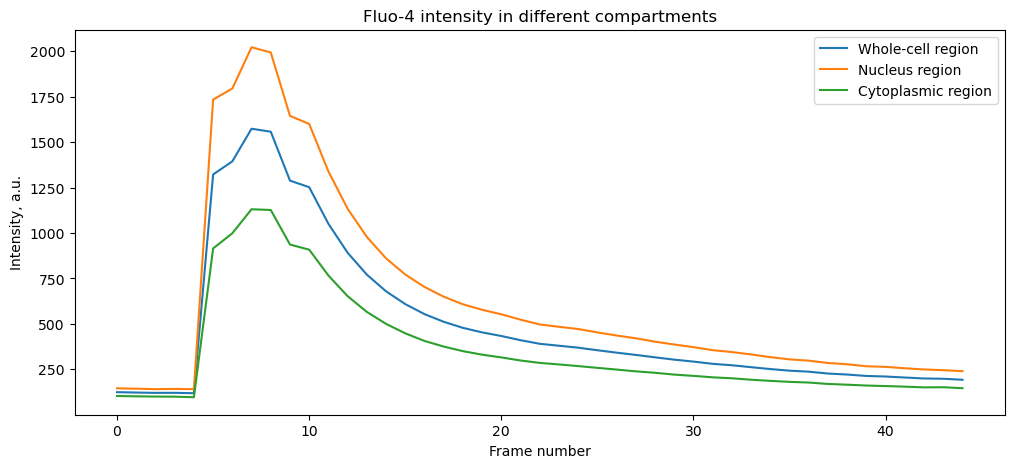

In [28]:
ch0_cell_prof = np.mean(ch0_img_processed, where=cell_mask, axis=(1,2))
ch0_nucleus_prof = np.mean(ch0_img_processed, where=nucleus_mask, axis=(1,2))
ch0_cytoplasm_prof = np.mean(ch0_img_processed, where=cytoplasm_mask, axis=(1,2))


plt.figure(figsize=(12,5))

plt.plot(ch0_cell_prof, label='Whole-cell region')
plt.plot(ch0_nucleus_prof, label='Nucleus region')
plt.plot(ch0_cytoplasm_prof, label='Cytoplasmic region')

plt.xlabel('Frame number')
plt.ylabel('Intensity, a.u.')
plt.title('Fluo-4 intensity in different compartments')

plt.legend()
plt.show()

Профілі для HPCA-TagRFP

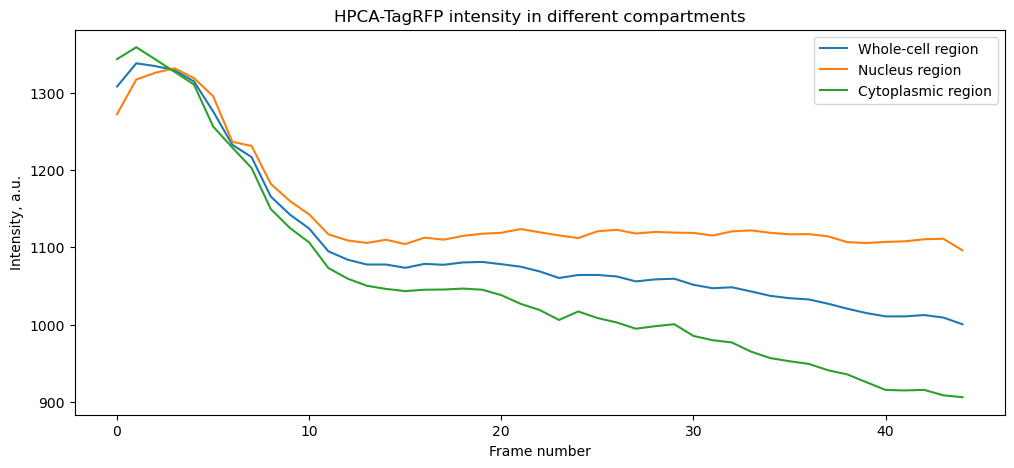

In [29]:
ch1_cell_prof = np.mean(ch1_img_processed, where=cell_mask, axis=(1,2))
ch1_nucleus_prof = np.mean(ch1_img_processed, where=nucleus_mask, axis=(1,2))
ch1_cytoplasm_prof = np.mean(ch1_img_processed, where=cytoplasm_mask, axis=(1,2))


plt.figure(figsize=(12,5))

plt.plot(ch1_cell_prof, label='Whole-cell region')
plt.plot(ch1_nucleus_prof, label='Nucleus region')
plt.plot(ch1_cytoplasm_prof, label='Cytoplasmic region')

plt.xlabel('Frame number')
plt.ylabel('Intensity, a.u.')
plt.title('HPCA-TagRFP intensity in different compartments')

plt.legend()
plt.show()

#### Побудова профілів похідної інтенсивності та визначення кадрів із стимуляціями 

Профіль загальної інтенсивності в кадрі та профіль похідної інтенсивності для каналу кальцієвого барвника

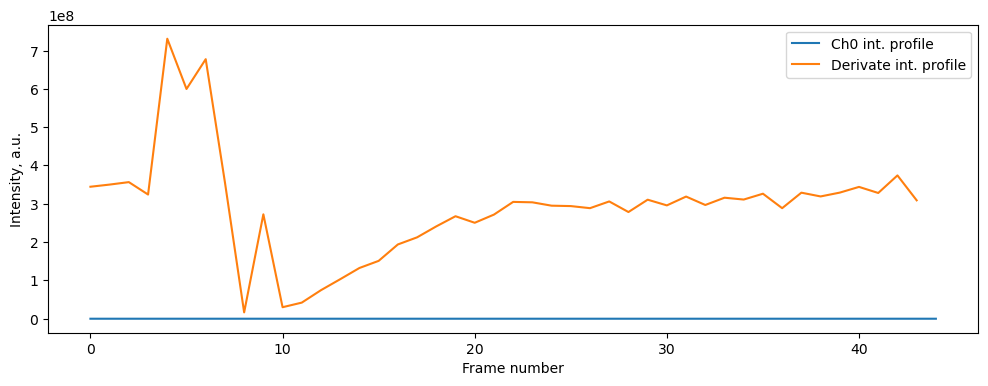

In [30]:
ch0_derivate_prof = np.asarray([np.sum(np.abs(ma.masked_where(~cytoplasm_mask, frame)))
                               for frame in (ch0_img_processed[:-1] - ch0_img_processed[1:])])  # профіль похідної інтенсивності для канала 0


# plot
plt.figure(figsize=(12, 4))
plt.plot(ch0_cytoplasm_prof, label='Ch0 int. profile') # профіль похідної інтенсивності для канала 0
plt.plot(ch0_derivate_prof, label='Derivate int. profile') # профіль похідної інтенсивності для канала 0

plt.xlabel('Frame number')
plt.ylabel('Intensity, a.u.')

plt.legend()
plt.show()

Нормалізація інтенсивності

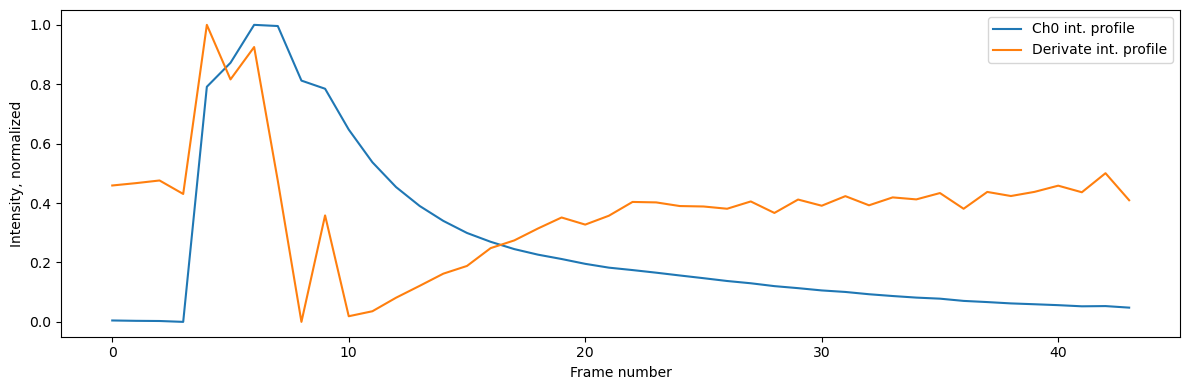

In [31]:
ch0_cytoplasm_prof_norm = (ch0_cytoplasm_prof - np.min(ch0_cytoplasm_prof))/(np.max(ch0_cytoplasm_prof)-np.min(ch0_cytoplasm_prof))
ch0_derivate_prof_norm = (ch0_derivate_prof - np.min(ch0_derivate_prof))/(np.max(ch0_derivate_prof)-np.min(ch0_derivate_prof))


# plot
plt.figure(figsize=(12, 4))

plt.plot(ch0_cytoplasm_prof_norm[1:], label='Ch0 int. profile')  # профіль інтенсивності для канала 0
plt.plot(ch0_derivate_prof_norm, label='Derivate int. profile')  # профіль похідної інтенсивності для канала 0

plt.xlabel('Frame number')
plt.ylabel('Intensity, normalized')

plt.legend()
plt.tight_layout()
plt.show()

Детекція піків зміни інтенсивносі кальцієвого барвника

Derivate calcium dye profile peak index: [4]
Intensity calcium dye profile peak index: [7]


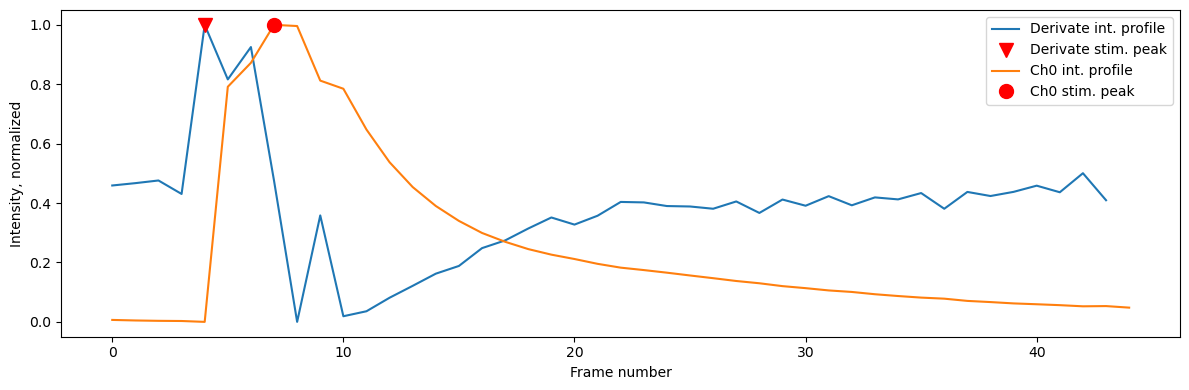

In [32]:
derivate_peaks_idx, derivate_peaks_prop = signal.find_peaks(ch0_derivate_prof_norm, prominence=0.5)
intensity_peaks_idx, intensity_peaks_prop = signal.find_peaks(ch0_cytoplasm_prof_norm, prominence=0.5)

print(f'Derivate calcium dye profile peak index: {derivate_peaks_idx}')
print(f'Intensity calcium dye profile peak index: {intensity_peaks_idx}')


# plot
plt.figure(figsize=(12, 4))

plt.plot(ch0_derivate_prof_norm, label='Derivate int. profile') # профіль похідної інтенсивності для канала 0
plt.plot(derivate_peaks_idx, ch0_derivate_prof_norm[derivate_peaks_idx],
         'v', label='Derivate stim. peak', markersize=10, color='red')  # положення детектованих піків стимуляції

plt.plot(ch0_cytoplasm_prof_norm, label='Ch0 int. profile') # профіль похідної інтенсивності для канала 0
plt.plot(intensity_peaks_idx, ch0_cytoplasm_prof_norm[intensity_peaks_idx],
         'o', label='Ch0 stim. peak', markersize=10, color='red')  # положення детектованих піків стимуляції


plt.xlabel('Frame number')
plt.ylabel('Intensity, normalized')

plt.legend()
plt.tight_layout()
plt.show()

Розрахунок відностної зміни інтенсивності, ΔF/F0

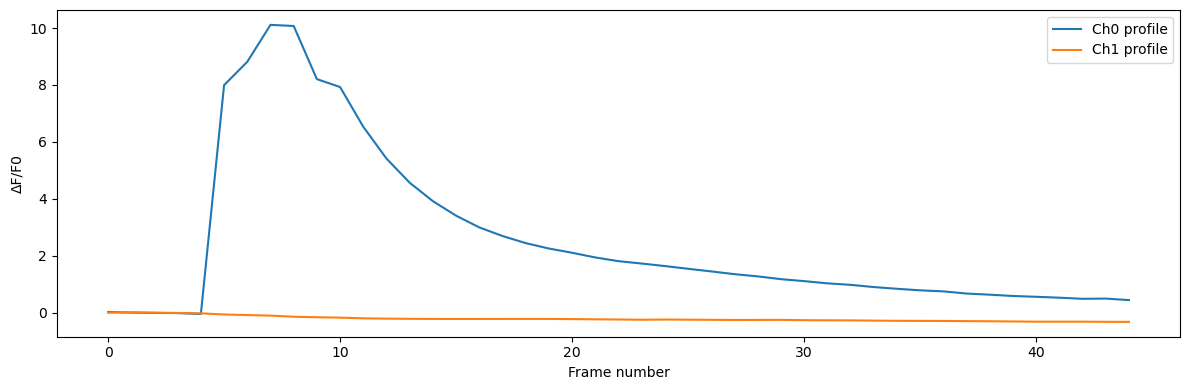

In [33]:
def calc_dff_profile(input_profile, df_window=3):
    ''' Функція для розрахунку відносної інтенсивності профілю.
    input_profile : 1D numpy array, профіль інтенсивності із абсолютнми значеннями вимірювань
    df_window : int=3, кільклькість точок від початку профіля що будуть використані для обчислення початкової інтенсивності
    
    '''
    f_0 = np.mean(input_profile[:df_window])
    df_profile = input_profile - f_0
    dff_profile = df_profile / f_0

    return dff_profile

ch0_cytoplasm_dff_prof = calc_dff_profile(ch0_cytoplasm_prof)
ch1_cytoplasm_dff_prof = calc_dff_profile(ch1_cytoplasm_prof)


# plot
plt.figure(figsize=(12, 4))

plt.plot(ch0_cytoplasm_dff_prof, label='Ch0 profile')  # профіль відносної інтенсивності для канала 0
plt.plot(ch1_cytoplasm_dff_prof, label='Ch1 profile')  # профіль відносної інтенсивності для канала 1

plt.xlabel('Frame number')
plt.ylabel('ΔF/F0')

plt.legend()
plt.tight_layout()
plt.show()

#### Збереження результатів аналізу

In [34]:
int_data_frame = pd.DataFrame({'cell_ID':np.full(ch0_cytoplasm_prof.shape[0], 'cell_1'),
                               'channel':np.full(ch0_cytoplasm_prof.shape[0], 'ch0'),
                               'index':np.arange(0, ch0_cytoplasm_prof.shape[0], dtype=int),
                               'abs_int':ch0_cytoplasm_prof, 
                               'dff_int':ch0_cytoplasm_dff_prof})

int_data_frame.to_csv('int_data_frame.csv', index=False)

In [35]:
data_frame = pd.read_csv('int_data_frame.csv')
data_frame

cell_ID channel  index      abs_int    dff_int
0   cell_1     ch0      0   103.417921   0.016526
1   cell_1     ch0      1   101.520188  -0.002127
2   cell_1     ch0      2   100.271737  -0.014399
3   cell_1     ch0      3    99.667434  -0.020339
4   cell_1     ch0      4    96.641137  -0.050085
5   cell_1     ch0      5   915.163981   7.995424
6   cell_1     ch0      6   998.565699   8.815205
7   cell_1     ch0      7  1130.749867  10.114483
8   cell_1     ch0      8  1126.655038  10.074234
9   cell_1     ch0      9   936.630158   8.206421
10  cell_1     ch0     10   908.278555   7.927745
11  cell_1     ch0     11   766.149991   6.530720
12  cell_1     ch0     12   652.359749   5.412242
13  cell_1     ch0     13   565.989375   4.563281
14  cell_1     ch0     14   500.110590   3.915738
15  cell_1     ch0     15   448.155127   3.405052
16  cell_1     ch0     16   406.193554   2.992599
17  cell_1     ch0     17   375.441739   2.690331
18  cell_1     ch0     18   350.016115   2.440414
19  cell_1     ch0     19   330.677351   2.250328
20  cell_1     ch0     20   315.505490   2.101199
21  cell_1     ch0     21   298.696830   1.935982
22  cell_1     ch0     22   285.414025   1.805421
23  cell_1     ch0     23   276.985213   1.722572
24  cell_1     ch0     24   267.910395   1.633372
25  cell_1     ch0     25   258.168408   1.537615
26  cell_1     ch0     26   248.741190   1.444952
27  cell_1     ch0     27   238.956968   1.348780
28  cell_1     ch0     28   231.048787   1.271048
29  cell_1     ch0     29   221.078006   1.173043
30  cell_1     ch0     30   214.040553   1.103869
31  cell_1     ch0     31   206.112803   1.025945
32  cell_1     ch0     32   200.809633   0.973819
33  cell_1     ch0     33   192.859306   0.895673
34  cell_1     ch0     34   186.632991   0.834472
35  cell_1     ch0     35   181.129007   0.780372
36  cell_1     ch0     36   177.422083   0.743935
37  cell_1     ch0     37   169.649637   0.667538
38  cell_1     ch0     38   165.564282   0.627381
39  cell_1     ch0     39   160.928015   0.581810
40  cell_1     ch0     40   157.983443   0.552867
41  cell_1     ch0     41   154.817248   0.521746
42  cell_1     ch0     42   150.826634   0.482521
43  cell_1     ch0     43   151.611298   0.490233
44  cell_1     ch0     44   146.210466   0.437147

## Завдання

- __Напишіть функцію для побудови профілів інтенсивності за маскою__

Створіть функцію що приймала би на вхід 3D time series (`input_img`) та 2D маску (`input_mask`) і будувала графік інтенсивності. Аргументами функції окрім зображення та маски можуть бути підписи для осей графіка. 

- __Напишіть функцію для збереження профіля інтенсивності за маскою у форматі CSV__

Створіть функцію що приймала би на вхід 3D time series (`input_img`) та 2D маску (`input_mask`) і зберігала data frame у форматі CSV з середньою інтенсивністю за маскою для кожного кадру зображення. Аргументами функції окрім зображення та маски можуть бути канал для якого будуть розраховуватися профілі та назва data frame. 

# 5. Побудова масок регіонів зміни інтенсивності
---

## Аналіз даних

#### Створення диференційного зображення перерозподілу інтенсивності після стимулу

Створення контрольних зображень транслокацій

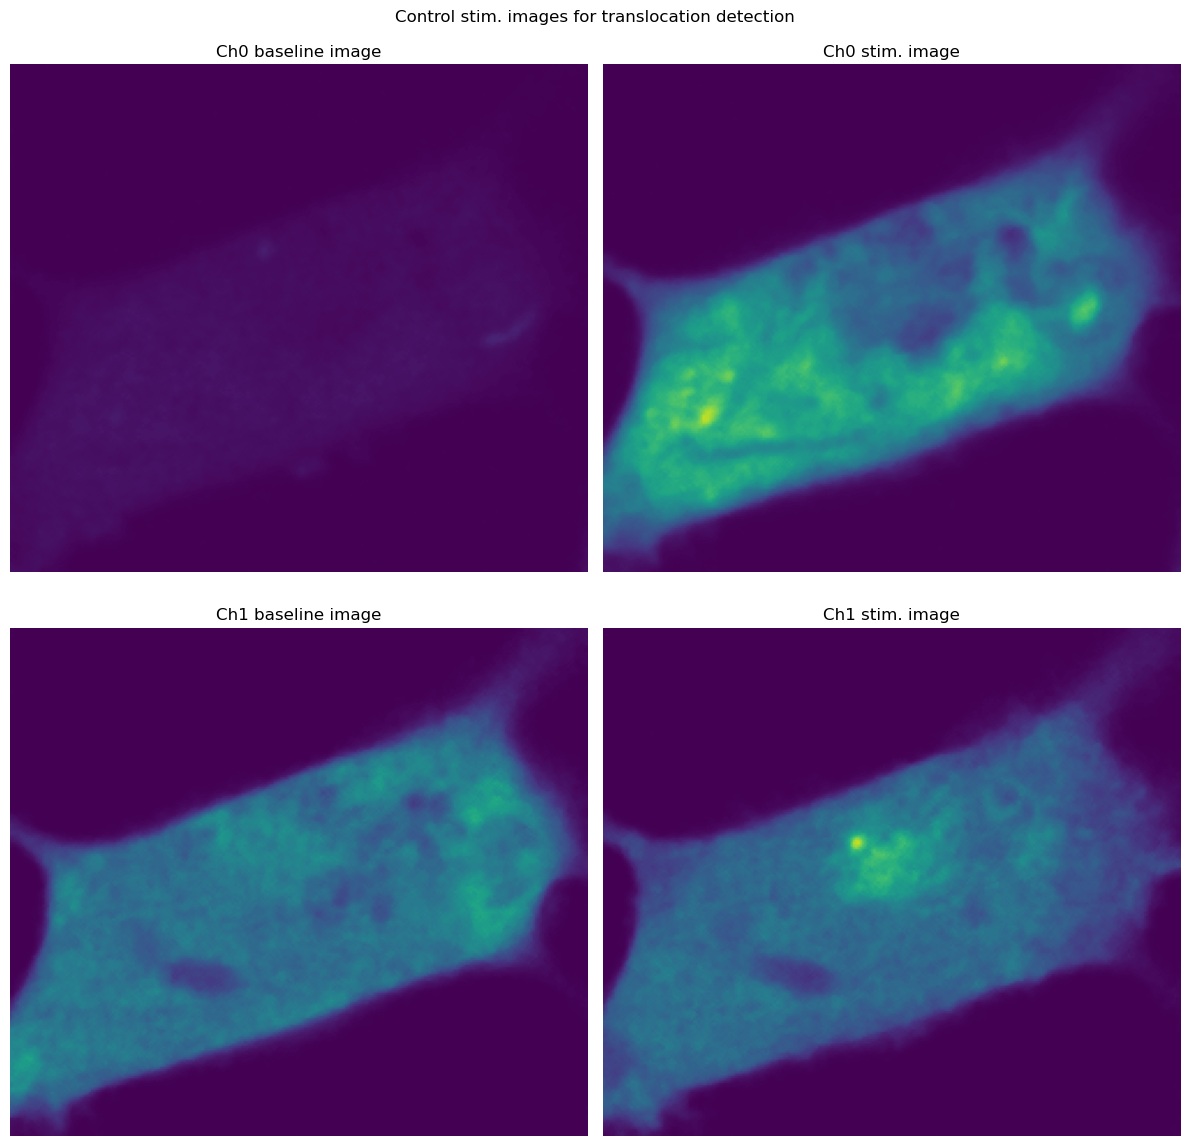

In [36]:
base_win = 3  # кількість кадрів для отримання контрольного зображення базової інтенсивності
stim_win = 3  # кількість зоборажень для отриамння контрольного зображення після стимуляції

# обчислення меж інтенсивності серії зображень в каналі флуоресцентного білка
ch0_int_lim_min, ch0_int_lim_max = np.min(ch0_img_processed), np.max(ch0_img_processed)
ch1_int_lim_min, ch1_int_lim_max = np.min(ch1_img_processed), np.max(ch1_img_processed)

# обчислення контрольних зображень базової інтенсивності та після стимуляції
ch0_baseline_image = np.mean(ch0_img_processed[:base_win], axis=0)
ch0_stimulus_image = np.mean(ch0_img_processed[intensity_peaks_idx[0]:intensity_peaks_idx[0]+stim_win], axis=0)

ch1_baseline_image = np.mean(ch1_img_processed[:base_win], axis=0)
ch1_stimulus_image = np.mean(ch1_img_processed[intensity_peaks_idx[0]:intensity_peaks_idx[0]+stim_win], axis=0)


# plot
plt.figure(figsize=(12,12))

ax0 = plt.subplot(221)
ax0.imshow(ch0_baseline_image, vmin=ch0_int_lim_min, vmax=ch0_int_lim_max)
ax0.set_title('Ch0 baseline image')
ax0.axis('off')

ax1 = plt.subplot(222)
ax1.imshow(ch0_stimulus_image, vmin=ch0_int_lim_min, vmax=ch0_int_lim_max)
ax1.set_title('Ch0 stim. image')
ax1.axis('off')

ax2 = plt.subplot(223)
ax2.imshow(ch1_baseline_image, vmin=ch1_int_lim_min, vmax=ch1_int_lim_max)
ax2.set_title('Ch1 baseline image')
ax2.axis('off')

ax3 = plt.subplot(224)
ax3.imshow(ch1_stimulus_image, vmin=ch1_int_lim_min, vmax=ch1_int_lim_max)
ax3.set_title('Ch1 stim. image')
ax3.axis('off')

plt.suptitle('Control stim. images for translocation detection')
plt.tight_layout()
plt.show()

Кольорова мапа для зручної візуалізації диференціного зображення

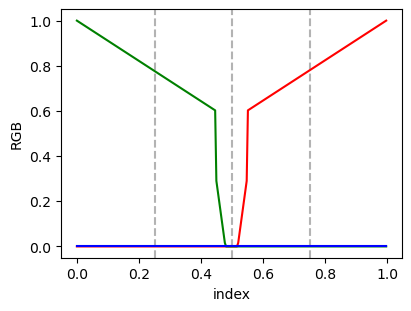

In [37]:
# red-green cmap creation
dict_red_green = {'red':(
                   (0.0, 0.0, 0.0),
                   (0.52, 0.0, 0.0),
                   (0.55, 0.3, 0.6),
                   (1.0, 1.0, 1.0)),
                   'blue':(
                   (0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
                   'green':(
                   (0.0, 1.0, 1.0),
                   (0.45, 0.6, 0.3),
                   (0.48, 0.0, 0.0),
                   (1.0, 0.0, 0.0))}
cmap_red_green = LinearSegmentedColormap('RedGreen', dict_red_green)


def plot_linearmap(cdict):
    newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)
    rgba = newcmp(np.linspace(0, 1, 256))
    fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
    col = ['r', 'g', 'b']
    for xx in [0.25, 0.5, 0.75]:
        ax.axvline(xx, color='0.7', linestyle='--')
    for i in range(3):
        ax.plot(np.arange(256)/256, rgba[:, i], color=col[i])
    ax.set_xlabel('index')
    ax.set_ylabel('RGB')
    plt.show()
plot_linearmap(dict_red_green)

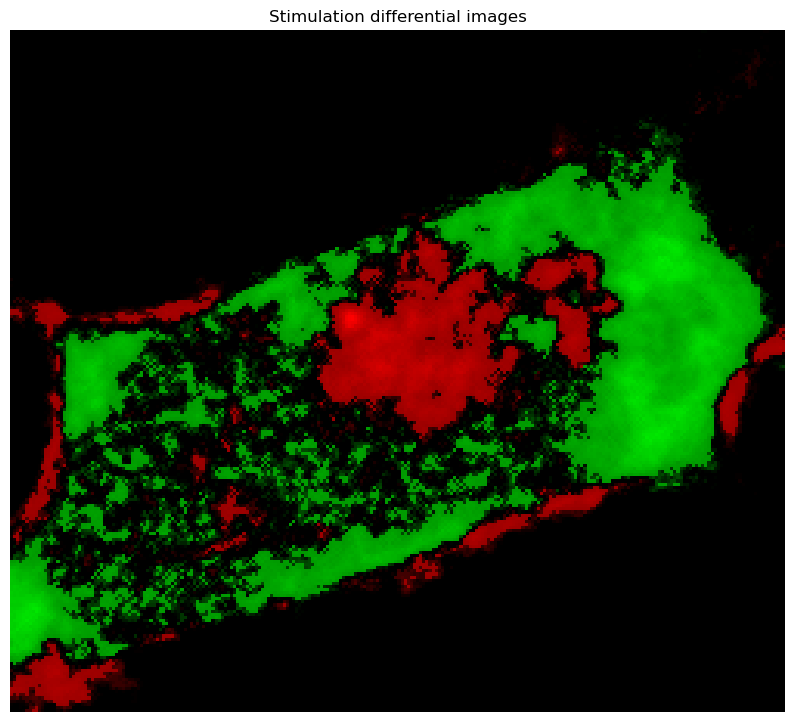

In [38]:
# обчислення та нормалізація диференційних зображень транслокації після кожної стимуляції
differential_image = ch1_stimulus_image - ch1_baseline_image
differential_image = differential_image / np.max(np.abs(differential_image))


# plot
plt.figure(figsize=(10,10))
plt.imshow(differential_image, vmin=-1, vmax=1, cmap=cmap_red_green)
plt.axis('off')
plt.title('Stimulation differential images')
plt.show()

#### Побудова масок регіонів транслокації

Побудова масок регіонів збільшення інтенсивності (__up mask__)

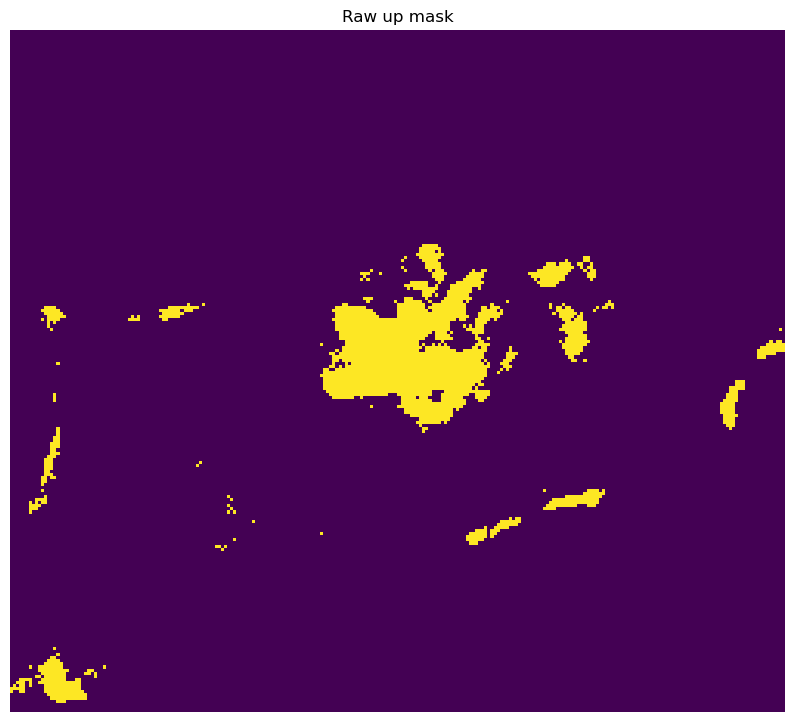

In [39]:
up_threshold = 0.15  # поріг мінімальної інтенсивності диференційних зображень стимулцій для детекції регіонів збільшення інтенсивності
up_mask_raw = differential_image >= up_threshold


# plot
plt.figure(figsize=(10,10))
plt.imshow(up_mask_raw)
plt.axis('off')
plt.title('Raw up mask')
plt.show()

Побудова маски регіонів зменшення інтенсивності (__down mask__)

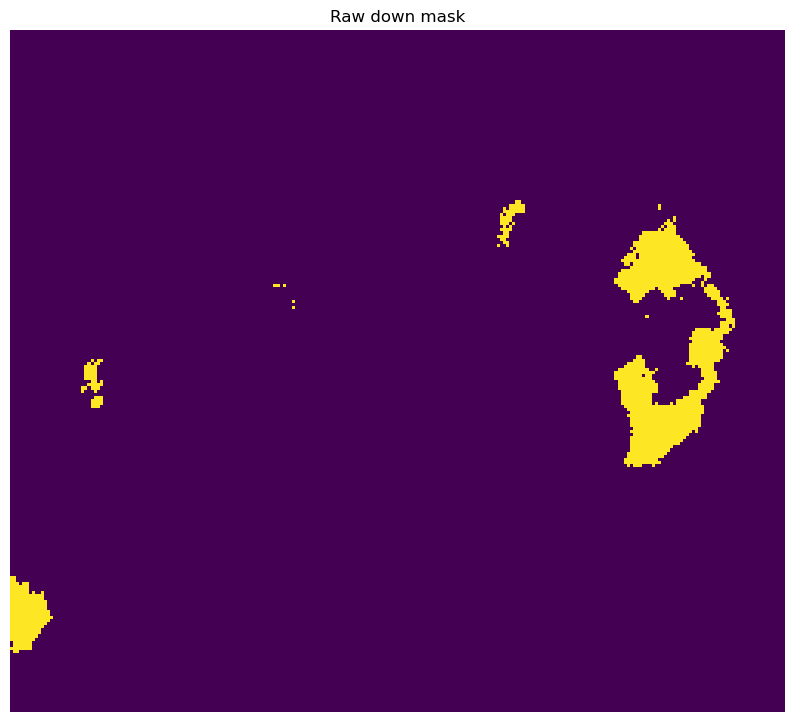

In [40]:
down_threshold = -0.45  # поріг мінімальної інтенсивності диференційних зображень стимулцій для детекції регіонів зменшення інтенсивності  
down_mask_raw = differential_image <= down_threshold


# plot
plt.figure(figsize=(10,10))
plt.imshow(down_mask_raw)
plt.axis('off')
plt.title('Raw down mask')
plt.show()

Фільтрація сирих масок

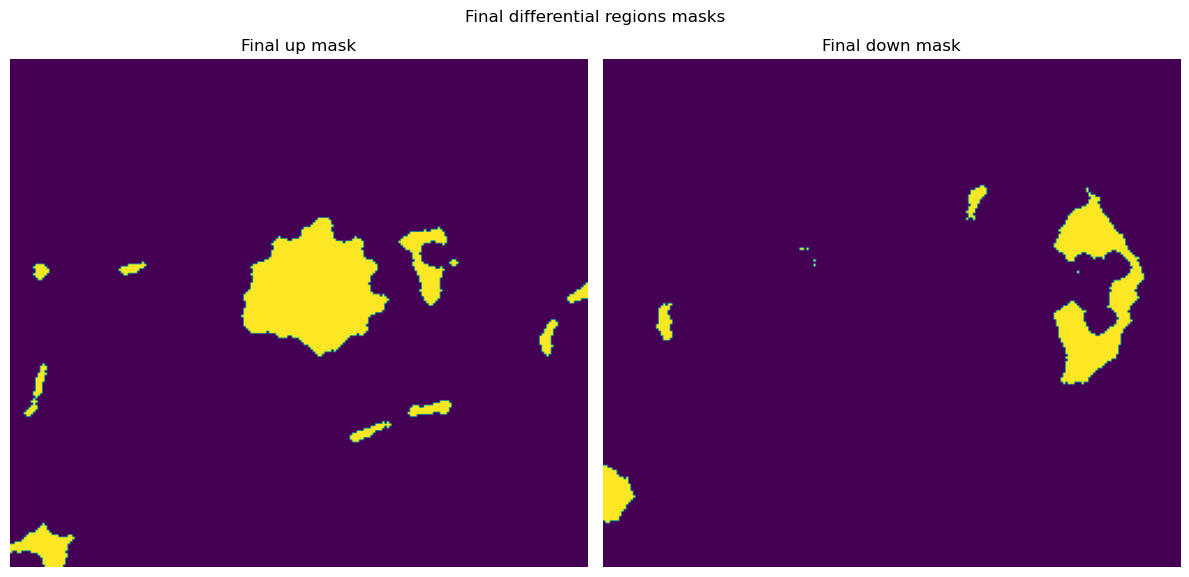

In [41]:
def mask_filtering(input_mask, cls_size=7, op_size=1):
    """ Функція для фільтрації маски регіонів транслокації послідовним морфологічними відкриванням та закриванням.

    Input:
      input_mask : boolean numpy array, вхідна макска
      cls_size : int=7, розмір структурного елементу для морфологічного закривання в пікселях
      op_size : int=1, розмір структурного елементу для морфологічного відкривання в пікселях

    Output:
      output_mask : boolean numpy array, модифікована булева маска

    """
    output_mask = morphology.closing(input_mask, footprint=morphology.disk(cls_size))
    output_mask = morphology.opening(output_mask, footprint=morphology.disk(op_size))

    return output_mask 

up_mask = mask_filtering(up_mask_raw, cls_size=5, op_size=1)
down_mask = mask_filtering(down_mask_raw, cls_size=4, op_size=0)


# plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # маска цитоплазматичног регіона
ax0.imshow(up_mask)
ax0.set_title('Final up mask')
ax0.axis('off')

ax1 = plt.subplot(122)  # маска цілої клітини
ax1.imshow(down_mask)
ax1.set_title('Final down mask')
ax1.axis('off')

plt.suptitle('Final differential regions masks')
plt.tight_layout()
plt.show()

# Demo data processing

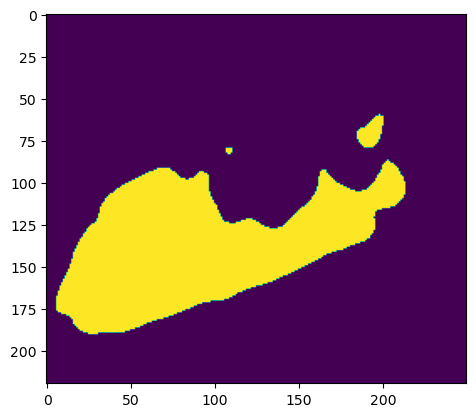

In [45]:
plt.imshow(nucleus_mask)

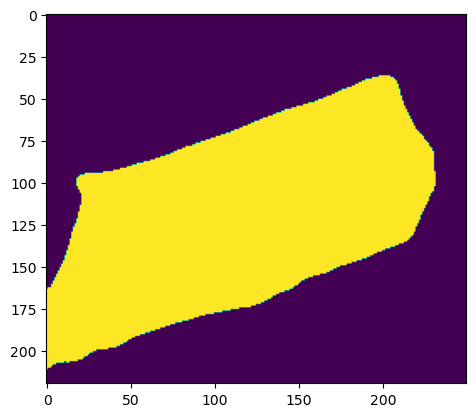

In [50]:

plt.imshow(cell_mask)

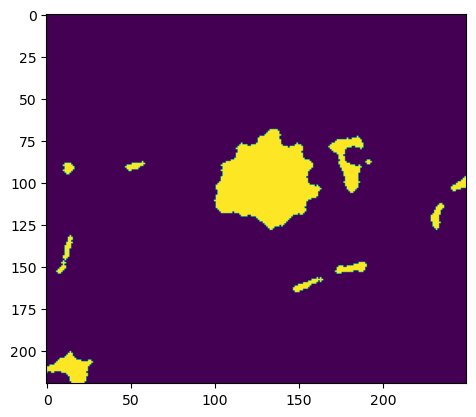

In [52]:
demo_mask = np.copy(up_mask)
plt.imshow(demo_mask)

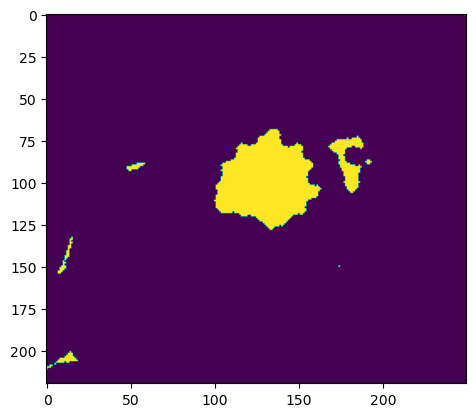

In [53]:
demo_mask[~cell_mask] = 0
plt.imshow(demo_mask)

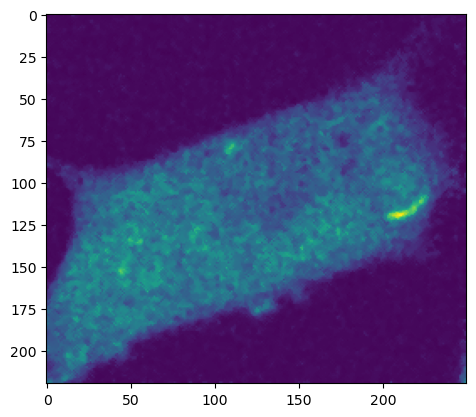

In [57]:
demo_img = ch0_img_processed[0]
plt.imshow(demo_img)

8

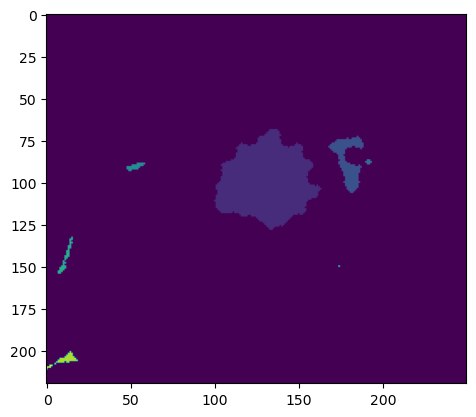

In [56]:
demo_label = measure.label(demo_mask)
plt.imshow(demo_label)
np.max(demo_label)

In [77]:
list(range(1, np.max(demo_label)+1))

[1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:

df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
# List of new rows as DataFrames
new_rows = [pd.DataFrame([[7, 8]], columns=df.columns), pd.DataFrame([[9, 10]], columns=df.columns)]
# Concatenate the original DataFrame with the new rows
df = pd.concat([df] + new_rows, ignore_index=True)
# Display the resulting DataFrame
print(df)

In [87]:
demo_df = pd.DataFrame({'Int.':[], 'Area':[], 'Dens.':[]})

for label_num in range(1, np.max(demo_label)+1):
    demo_fragment = demo_label == label_num

    int_sum = np.sum(demo_img, where=demo_fragment)
    fragment_area = np.sum(demo_fragment) 
    int_dens = int_sum / fragment_area

    new_row = [int_sum, fragment_area, int_dens]
    demo_df.loc[len(demo_df.index)] = new_row


    print(f'Int.={int_sum}, area={fragment_area}, int. density={int_dens}')

demo_df

Int.=248887, area=2361, int. density=105.41592545531554
Int.=27875, area=295, int. density=94.49152542372882
Int.=838, area=8, int. density=104.75
Int.=1344, area=29, int. density=46.3448275862069
Int.=2996, area=43, int. density=69.67441860465117
Int.=119, area=1, int. density=119.0
Int.=6342, area=44, int. density=144.13636363636363
Int.=309, area=6, int. density=51.5


Int.  Area       Dens.
0  248887  2361  105.415925
1   27875   295   94.491525
2     838     8  104.750000
3    1344    29   46.344828
4    2996    43   69.674419
5     119     1  119.000000
6    6342    44  144.136364
7     309     6   51.500000

Int.=309, area=6, int. density=51.5
6


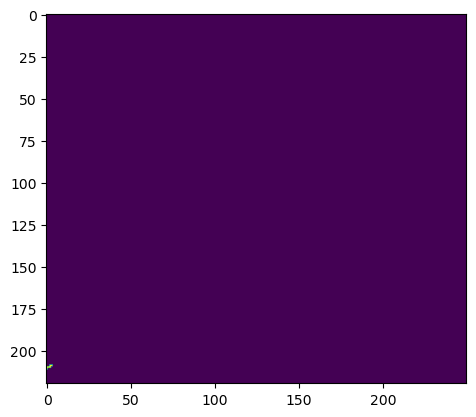

In [73]:
demo_fragment = demo_label == 8
int_sum = np.sum(demo_img, where=demo_fragment)
fragment_area = np.sum(demo_fragment) 
int_dens = int_sum / fragment_area

print(f'Int.={int_sum}, area={fragment_area}, int. density={int_dens}')

print(np.sum(demo_fragment))
plt.imshow(demo_fragment)

248887

#### Побудова профілів вбудовування за __up mask__

Побудова профілів для загальних __up mask__ та __down mask__

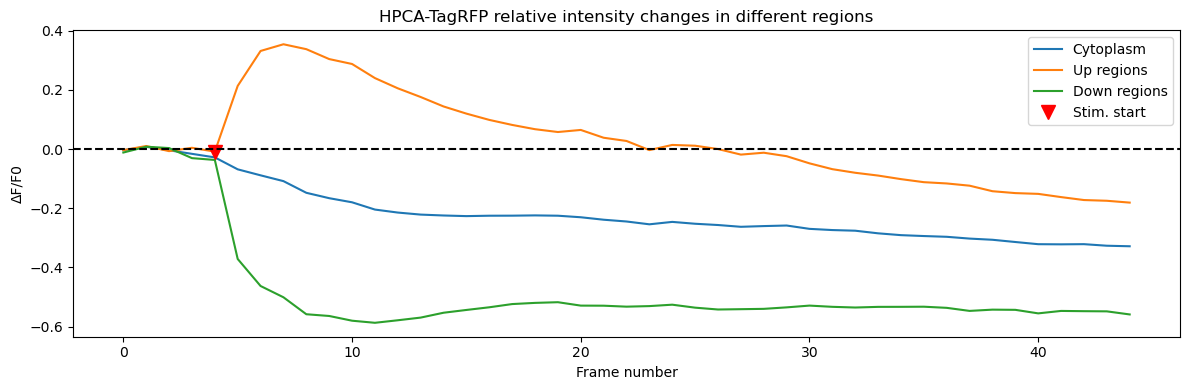

In [89]:
# обчислення профілю середньої інтенстивоті в регіонів up_mask та down_mask для зображень каналу флуоресцентного білка
ch1_up_mask_prof = np.asarray([np.mean(img, where=up_mask) for img in ch1_img_processed])
ch1_up_mask_dff_prof = calc_dff_profile(ch1_up_mask_prof)

ch1_down_mask_prof = np.asarray([np.mean(img, where=down_mask) for img in ch1_img_processed])
ch1_down_mask_dff_prof = calc_dff_profile(ch1_down_mask_prof)


# plot
plt.figure(figsize=(12, 4))
plt.plot(ch1_cytoplasm_dff_prof, label='Cytoplasm')  # профіль відносної інтенсивності для канала 1 в уитоплазмі
plt.plot(ch1_up_mask_dff_prof, label='Up regions')  # профіль відносної інтенсивності для канала 1 в регіонах збільшення
plt.plot(ch1_down_mask_dff_prof, label='Down regions')  # профіль відносної інтенсивності для канала 1 в регіонах зменшення

plt.plot(derivate_peaks_idx, ch1_up_mask_dff_prof[derivate_peaks_idx],
         'v', label='Stim. start', markersize=10, color='red')  # положення детектованого піку початку стимуляції

plt.axhline(0, linestyle='--', color='k')
plt.xlabel('Frame number')
plt.ylabel('ΔF/F0')
plt.title('HPCA-TagRFP relative intensity changes in different regions')

plt.legend()
plt.tight_layout()
plt.show()

Фрагментація маски регіонів вбудовування __up mask__

11


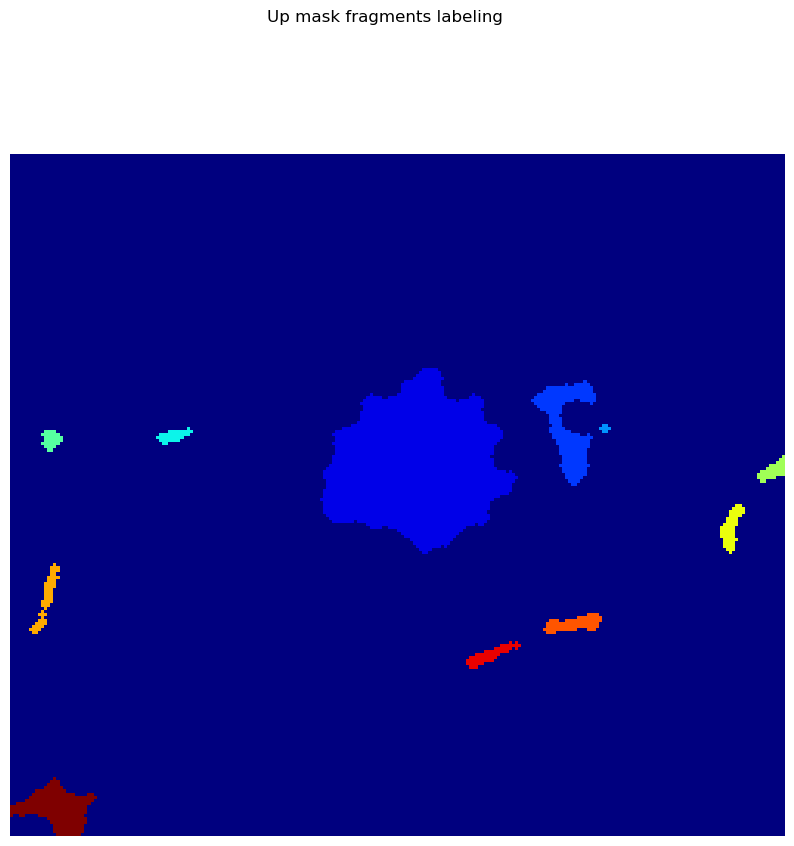

In [90]:
up_labels = measure.label(up_mask)
print(up_labels.max())

# plot
plt.figure(figsize=(10,10))
plt.imshow(up_labels, cmap='jet')  # промарковані окремі фрагменти up mask
plt.suptitle('Up mask fragments labeling')
plt.axis('off')
plt.show()

Функція для обчислення профілів для кожного врагменту маски

In [91]:
def calc_fragment_prof_arr(input_mask, input_img):
    """ Функція для обчислення профілів інтенсивності для кожного фрагменту маски

    Параметри
    ----------
    input_label: ndarray [x,y]
        маска з багатьма фрагментами
    input_img: ndarray [t,x,y]
        вхідне зображення, time series

    Returns
    -------
    prof_arr: ndarray [intensity_value,t]
        масив профілів абсолютної інтенсивності для кожного фрагменту маски
    dff_prof_arr: ndarray [intensity_value,t]
        масив профілів відносної інтенсивності для кожного фрагменту маски
 
    """
    input_labels = measure.label(input_mask)
    prof_arr = []
    dff_prof_arr = []

    for fragment_num in np.unique(input_labels)[1:]:
        fragment_mask = input_labels == fragment_num
        prof = np.mean(input_img, axis=(1,2), where=fragment_mask)

        prof_arr.append(prof)

        dff_prof = calc_dff_profile(prof)
        dff_prof_arr.append(dff_prof)
    
    return np.asarray(prof_arr), np.asarray(dff_prof_arr)

Побудова профілів кальцієвого барвника для кожного фрагменту __up mask__ окремо

(11, 45)


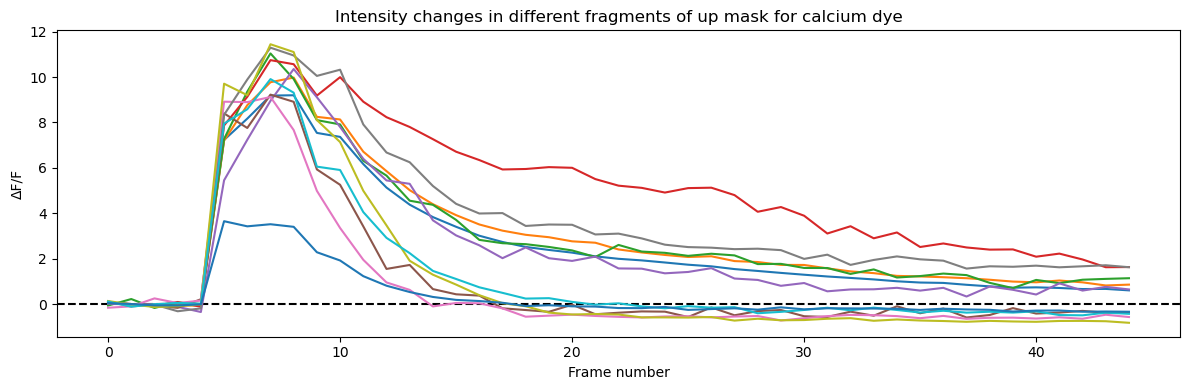

In [92]:
ch0_fragment_prof_arr, ch0_fragment_dff_prof_arr = calc_fragment_prof_arr(input_mask=up_mask, input_img=ch0_img_processed)
print(ch0_fragment_prof_arr.shape)

# plot
plt.figure(figsize=(12, 4))  # ініціалізація графіку для подальшого оновлення в циклі for
plt.axhline(0, linestyle='--', color='k')

# цикл for по окремих фрагментах
for one_prof in ch0_fragment_dff_prof_arr:
    plt.plot(one_prof)  # додавання профілю до існуючого графіку

plt.xlabel('Frame number')
plt.ylabel('ΔF/F')
plt.title('Intensity changes in different fragments of up mask for calcium dye')

plt.tight_layout()
plt.show()

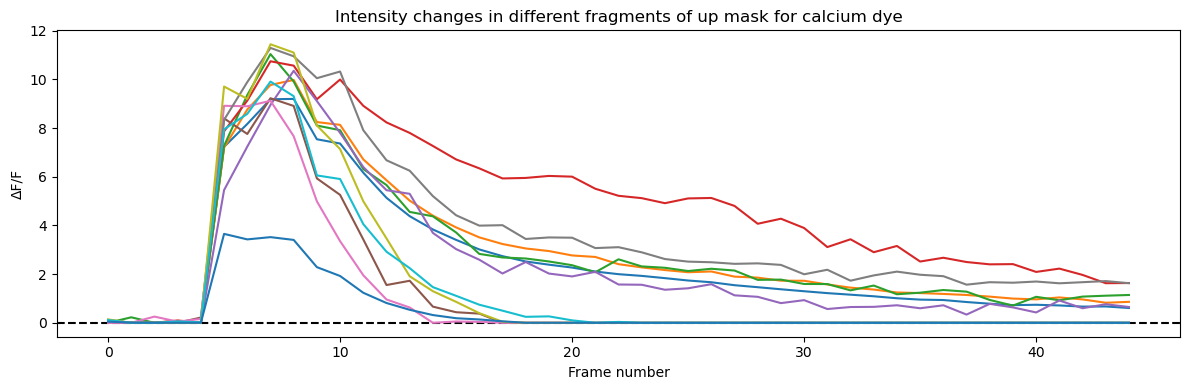

In [93]:
ch0_fragment_dff_prof_arr[ch0_fragment_dff_prof_arr < 0] = 0

# plot
plt.figure(figsize=(12, 4))  # ініціалізація графіку для подальшого оновлення в циклі for
plt.axhline(0, linestyle='--', color='k')

# цикл for по окремих фрагментах
for one_prof in ch0_fragment_dff_prof_arr:
    plt.plot(one_prof)  # додавання профілю до існуючого графіку

plt.xlabel('Frame number')
plt.ylabel('ΔF/F')
plt.title('Intensity changes in different fragments of up mask for calcium dye')

plt.tight_layout()
plt.show()

Побудова профілів HPCA-TagRFP для кожного фрагменту __up mask__ окремо

(11, 45)


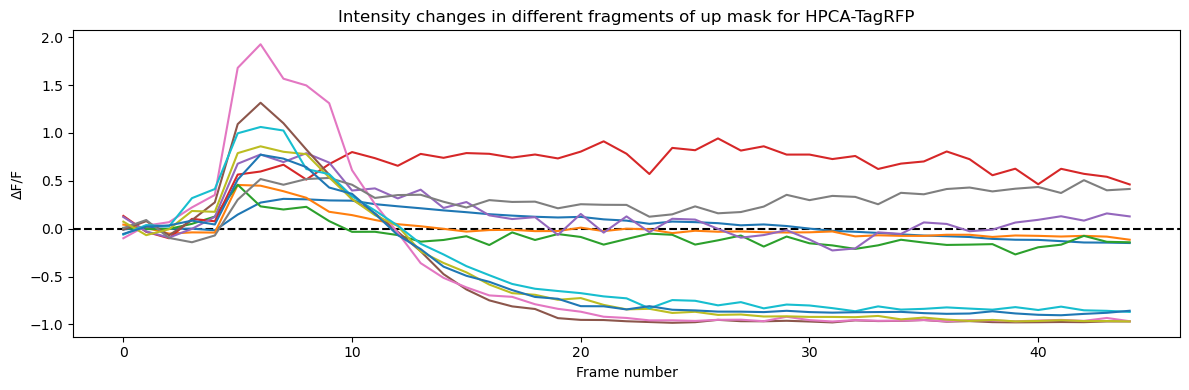

In [94]:
ch1_fragment_prof_arr, ch1_fragment_dff_prof_arr = calc_fragment_prof_arr(input_mask=up_mask, input_img=ch1_img_processed)
print(ch1_fragment_prof_arr.shape)


# plot
plt.figure(figsize=(12, 4))  # ініціалізація графіку для подальшого оновлення в циклі for
plt.axhline(0, linestyle='--', color='k')

# цикл for по окремих фрагментах
for one_prof in ch1_fragment_dff_prof_arr:
    plt.plot(one_prof)  # додавання профілю до існуючого графіку

plt.xlabel('Frame number')
plt.ylabel('ΔF/F')
plt.title('Intensity changes in different fragments of up mask for HPCA-TagRFP')

plt.tight_layout()
plt.show()

## Завдання

- __Напишіть функцію для побудови up mask__

Створіть функцію що приймала би на вхід 3D time series (`input_img`), індекс кадру максимальної відповіді на стимуляцю (`intensity_peaks`), кількість кадрів для отримання зображення базової інтенсивності (`base_win`) та кількість кадрів для отриамння контрольного зображення після стимуляції (`stim_win`). На виході функції має бути отримана маска регіонів збільшення інтенсивності, за можливості включіть у функцію морфологісну фільтрацію маски для покращення її якості.

# 6. Оцінка біофізичних параметрів за допомогою лінійної моделі
---

## Аналіз даних

#### Побудова профілю дозо-залежності вбудовування від внутрішньоклітинної концентрації іонів кальцію

Обчислення Y для профілів HPCA-TagRFP

In [112]:
def calc_fragment_sum_prof_arr(input_mask, input_img):
    """ Функція для обчислення профілів інтенсивності для кожного фрагменту маски

    Параметри
    ----------
    input_label: ndarray [x,y]
        маска з багатьма фрагментами
    input_img: ndarray [t,x,y]
        вхідне зображення, time series

    Returns
    -------
    prof_arr: ndarray [intensity_value,t]
        масив профілів абсолютної інтенсивності для кожного фрагменту маски
    dff_prof_arr: ndarray [intensity_value,t]
        масив профілів відносної інтенсивності для кожного фрагменту маски
 
    """
    input_labels = measure.label(input_mask)
    prof_arr = []

    for fragment_num in np.unique(input_labels)[1:]:
        fragment_mask = input_labels == fragment_num
        prof = np.sum(input_img, axis=(1,2), where=fragment_mask)

        prof_arr.append(prof)
    
    return np.asarray(prof_arr)

In [89]:
p_0 = np.sum(ch1_img_processed, where=cytoplasm_mask, axis=(1,2))
# pl = calc_fragment_sum_prof_arr(input_mask=up_labels, input_img=ch1_img_processed)
pl = ch1_fragment_prof_arr

y_prof = pl / p_0
# y_prof = ch1_up_mask_dff_prof / ch1_cytoplasm_dff_prof


# plot
plt.figure(figsize=(12, 4))  # ініціалізація графіку для подальшого оновлення в циклі for
plt.axhline(0, linestyle='--', color='k')

# цикл for по окремих фрагментах
for one_prof in y_prof:
    plt.plot(one_prof)  # додавання профілю до існуючого графіку

plt.xlabel('Frame number')
plt.ylabel('Y')
plt.title('Y values in different fragments of up mask for HPCA-TagRFP')

plt.tight_layout()
plt.show()

NameError: name 'ch1_fragment_prof_arr' is not defined

Побудова графіка дозо-залежності

(5, 2, 13)


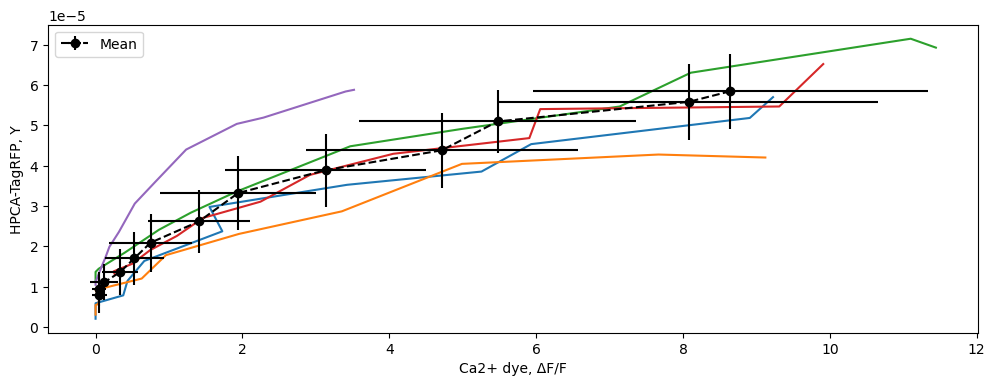

In [164]:
tail_start_idx = 7  # індекс початку спаду інтенсинвості кальцієвого барвника після останньої стимуляції
tail_end_idx = 20

ca_prof_arr = ch0_fragment_dff_prof_arr[:,tail_start_idx:tail_end_idx]
y_prof_arr = y_prof[:,tail_start_idx:tail_end_idx]

filtered_prof_arr = np.array([[y_prof, ca_prof] for y_prof, ca_prof in zip(y_prof_arr, ca_prof_arr) if y_prof[-1] < 0.00003])  # опціональна фільтрація профілів
print(filtered_prof_arr.shape)

y_mean_prof = np.mean(filtered_prof_arr[:,0,:], axis=0)


y_sd_prof = np.std(filtered_prof_arr[:,0,:], axis=0)


ca_mean_prof = np.mean(filtered_prof_arr[:,1,:], axis=0)



ca_sd_prof = np.std(filtered_prof_arr[:,1,:], axis=0)

# plot
plt.figure(figsize=(12, 4))

for one_prof_idx in range(filtered_prof_arr.shape[0]):  # відображення дозо-залежностей для профілю кожного окремого фрагменту up mask
    plt.plot(filtered_prof_arr[one_prof_idx,1],
             filtered_prof_arr[one_prof_idx,0])

plt.errorbar(ca_mean_prof, y_mean_prof,
             xerr=ca_sd_prof, yerr=y_sd_prof,
             linestyle='--', linewidth=1.5, marker='o',
             color='k', label='Mean')

plt.xlabel('Ca2+ dye, ΔF/F')
plt.ylabel('HPCA-TagRFP, Y')
plt.legend()

plt.show()

#### Побудова лінійної моделі та оцінка коефіцієнтів

(13, 2)
h = 0.381+/-0.01542
Kd = 0.000025+/-0.02707
R^2 = 0.991


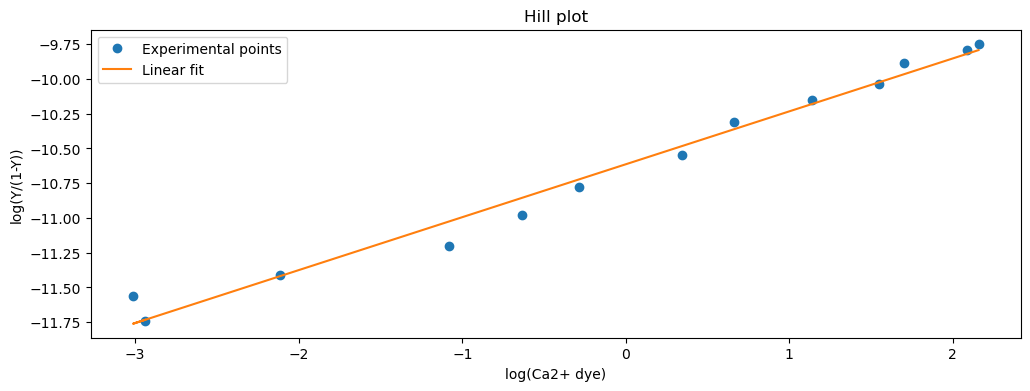

In [157]:
ca_log_prof = np.log(ca_mean_prof)
y_log_prof = np.log(y_mean_prof / (np.ones_like(y_mean_prof) - y_mean_prof))

filtered_log_arr = np.array([[y_prof, ca_prof] for y_prof, ca_prof in zip(y_log_prof, ca_log_prof) if not np.isinf(ca_prof)])  # опціональна фільтрація профілів
print(filtered_log_arr.shape)

hill_linear_model = stats.linregress(filtered_log_arr[:,-1], filtered_log_arr[:,0])

h_val = hill_linear_model.slope
h_val_err = hill_linear_model.stderr

k_d_val = np.e ** hill_linear_model.intercept
k_d_val_err = hill_linear_model.intercept_stderr

print(f"h = {h_val:.3f}+/-{h_val_err:.5f}")
print(f"Kd = {k_d_val:.6f}+/-{k_d_val_err:.5f}")
print(f"R^2 = {hill_linear_model.rvalue:.3f}")


# plot
plt.figure(figsize=(12, 4))

plt.plot(filtered_log_arr[:,-1], filtered_log_arr[:,0], 'o', label='Experimental points')
plt.plot(filtered_log_arr[:,-1], hill_linear_model.intercept + hill_linear_model.slope*ca_log_prof, label='Linear fit')

plt.xlabel('log(Ca2+ dye)')
plt.ylabel('log(Y/(1-Y))')
plt.title('Hill plot')
plt.legend()

plt.show()

In [158]:
ca_log_prof

array([ 2.15680977,  2.0891588 ,  1.69996443,  1.55075971,  1.14160569,
        0.66356626,  0.34293708, -0.28927795, -0.6366542 , -1.08399445,
       -2.11688289, -3.01329719, -2.9401894 ])

## Завдання

- __Напишіть функцію оцінка коефіцієнта Хіла та Kd за профілями іноенсивності__

Створіть функцію що приймала би на вхід профіль абсолютної інтенсивності HPCA-TagRFP в регіонах підвищення (`input_protein_prof`), початкову загальну інтенсивність клітини (`p_0_val`) та профіль відносної інтенсивності кальцієвого барвника  (`input_ca_prof`). Функція має повертати значення коефіцієнта Хіла та Kd.